# pip install

In [ ]:
!pip install pyarrow
!pip install fastparquet
!pip install pyarabic
!pip install wordcloud matplotlib arabic-reshaper python-bidi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
!pip install arabic-reshaper python-bidi wordcloud

In [ ]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 68.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
!pip install gensim

# Prepare libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import arabic_reshaper
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyarabic.araby import tokenize
from bidi.algorithm import get_display
from nltk.util import bigrams, trigrams
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.layers import Embedding, Conv1D,  GlobalMaxPooling1D
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder

#Load data

<div dir="rtl">
حذف ملفات اللغة الانكليزية والفرنسية من مجموعة البيانات MADAR
 </div>

In [ ]:
MADAR = '/content/drive/My Drive/MADAR_Corpus'

files_to_delete = ['MADAR.corpus.English.index.tsv', 'MADAR.corpus.French.index.tsv']

for filename in files_to_delete:
    file_path = os.path.join(MADAR, filename)

    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted: {filename}")
    else:
        print(f"File not found: {filename}")

File not found: MADAR.corpus.English.index.tsv
File not found: MADAR.corpus.French.index.tsv


<div  dir="rtl">
تقسيم الجداول في مجموعة البيانات MADAR إلى train و test و validation بناء على قيم العمود split
</div>

In [ ]:
mapping = {
    'corpus-6-test-corpus-26-train': 'train',
    'corpus-6-test-corpus-26-dev': 'validation',
    'corpus-6-test-corpus-26-test': 'test',
    'corpus-6-train' : 'train',
    'corpus-6-dev' : 'validation'
}

for filename in os.listdir(MADAR):
    if filename.endswith('.tsv'):
        file_path = os.path.join(MADAR, filename)

        df = pd.read_csv(file_path, sep='\t')

        if 'split' in df.columns:
            df['split'] = df['split'].map(mapping).fillna(df['split'])

        df.to_csv(file_path, sep='\t', index=False)

<div dir="rtl">
توحيد التسمية في العمود split بالنسبة للتصنيفات في داتا MADAR

 </div>


In [ ]:
output_folders = {
    'train': os.path.join(MADAR, 'train'),
    'test': os.path.join(MADAR, 'test'),
    'validation': os.path.join(MADAR, 'validation')
}

for folder in output_folders.values():
    os.makedirs(folder, exist_ok=True)

for filename in os.listdir(MADAR):
    if filename.endswith('.tsv'):
        file_path = os.path.join(MADAR, filename)

        df = pd.read_csv(file_path, sep='\t')

        if 'split' in df.columns:
            for split_value, folder_path in output_folders.items():

                split_df = df[df['split'] == split_value]

                if not split_df.empty:
                    output_file = os.path.join(folder_path, filename)
                    split_df.to_csv(output_file, sep='\t', index=False)

<div dir="rtl">
توحيد اللاحقة لكل الملفات، تم تحويل اللاحقة في داتا MADAR إلى .parque، لأنها أكثر كفاءة من حيث الذاكرة والأداء
</div>

In [ ]:
input_folder = '/content/drive/My Drive/DATASET/VALIDATION'
output_folder = '/content/drive/My Drive/HW1_DATASET/VALIDATION'

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith('.tsv'):
        input_file = os.path.join(input_folder, filename)
        output_file = os.path.join(output_folder, filename.replace('.tsv', '.parquet'))

        df = pd.read_csv(input_file, sep='\t')

        df.to_parquet(output_file, index=False)

print("All files converted successfully!")


All files converted successfully!


<div>

</div>

<div dir = 'rtl'>
بالنسبة لداتا QADI، من الشرح الموجود في الموقع تبين ان لعمود label يحتوي على أرقام من 0 إلى 17.
كل رقم يمثل دولة من الدول العربية، حيث يكون الرقم 0 يمثل عمان، والرقم 1 يمثل السودان، وهكذا.
</div>

In [ ]:
qadi_train['label'].unique()

<div dir = 'rtl'>
وبناء عليه سأقوم باستبدال كل رقم بالعمود باسم البلد الذي يمثلها، كما سأقوم بتغيير اسم العود من label إلى country وذلك لسهولة التصنيف والدمج في الطلبات اللاحقة.
</div>

In [ ]:
label_to_country = {
    0: 'OM',
    1: 'SD',
    2: 'SA',
    3: 'KW',
    4: 'QA',
    5: 'LB',
    6: 'JO',
    7: 'SY',
    8: 'IQ',
    9: 'MA',
    10: 'EG',
    11: 'PL',
    12: 'YE',
    13: 'BH',
    14: 'DZ',
    15: 'AE',
    16: 'TN',
    17: 'LY'
}

files = {
    'train': '/content/drive/My Drive/HW1_DATASET/TRAIN/QADI_train.parquet',
    'test': '/content/drive/My Drive/HW1_DATASET/TEST/QADI_test.parquet',
    'validation': '/content/drive/My Drive/HW1_DATASET/VALIDATION/QADI_validation.parquet'
}

def process_file(file_path):
    df = pd.read_parquet(file_path, engine='pyarrow')

    df['country'] = df['label'].map(label_to_country)

    df = df.drop(columns=['label'])

    df.to_parquet(file_path, engine='pyarrow', index=False)

    print(f"Processed file: {file_path}")

for dataset_name, file_path in files.items():
    print(f"Processing {dataset_name} dataset...")
    process_file(file_path)
    print("-" * 30)

print("Processing complete!")


Processing complete!


In [ ]:
qadi_val = pd.read_parquet('/content/drive/My Drive/HW1_DATASET/QADI_validation.parquet', engine= 'pyarrow')
qadi_val['country'].unique()
#qadi_train.columns

# مهمة 01  : تحميل البيانات

## [1.1]

<div dir='rtl'>
بعد عمليات الفرز السابقة بالنسبة لمجوعة MADAR بناء على قيمة العمود split،
تم تجميع الجداول في ملفات منفصلة إلى train, test, validation، بالإضافة إلى جداول QADI التي كنت مصنفة مسبقا.
</div>

In [ ]:
df_train = '/content/drive/My Drive/HW1_DATASET/TRAIN'
df_test = '/content/drive/My Drive/HW1_DATASET/TEST'
df_validation = '/content/drive/My Drive/HW1_DATASET/VALIDATION'

<div dir='rtl'>
تجميع جداول MADAR في جدول واحد مع الحفاظ على التصنيف
</div>

In [ ]:
folder_path = '/content/drive/My Drive/HW1_DATASET/VALIDATION'
output_file = '/content/drive/My Drive/HW1_DATASET/VALIDATION/madar_validation.parquet'

dataframes = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".parquet"):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_parquet(file_path, engine='fastparquet')
        dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.to_parquet(output_file, engine='fastparquet', index=False)

print(f"Combined table saved to: {output_file}")


Combined table saved to: /content/drive/My Drive/HW1_DATASET/VALIDATION/madar_validation.parquet


In [ ]:
madar_train = pd.read_parquet('/content/drive/My Drive/HW1_DATASET/TRAIN/madar_train.parquet', engine= 'pyarrow')
madar_test = pd.read_parquet('/content/drive/My Drive/HW1_DATASET/TEST/madar_test.parquet', engine= 'pyarrow')
madar_validation = pd.read_parquet('/content/drive/My Drive/HW1_DATASET/VALIDATION/madar_validation.parquet', engine= 'pyarrow')

qadi_train = pd.read_parquet('/content/drive/My Drive/HW1_DATASET/QADI_train.parquet', engine= 'pyarrow')
qadi_test = pd.read_parquet('/content/drive/My Drive/HW1_DATASET/QADI_test.parquet', engine= 'pyarrow')
qadi_validation = pd.read_parquet('/content/drive/My Drive/HW1_DATASET/QADI_validation.parquet', engine= 'pyarrow')

<div dir = 'rtl'>
طباعة الحجم الكلي (MDAR & QADI) في كل مجموعة (train, test, validation)
</div>

In [ ]:
print(f"The shap of madar_train: {madar_train.shape}")
print(f"The shap of madar_test: {madar_test.shape}")
print(f"The shap of madar_validation: {madar_validation.shape}")

print(f"\nThe shap of qadi_train: {qadi_train.shape}")
print(f"The shap of qadi_test: {qadi_test.shape}")
print(f"The shap of qadi_validation: {qadi_validation.shape}")

The shap of madar_train: (95600, 4)
The shap of madar_test: (5200, 4)
The shap of madar_validation: (22400, 4)

The shap of qadi_train: (9164, 3)
The shap of qadi_test: (8982, 3)
The shap of qadi_validation: (9164, 3)


<div dir='rtl'>
فحص وجود missing values أو duplicate rows.
</div>

In [ ]:
def check_data_issues(df, df_name):

    print(f"Checking issues in {df_name}:")
    missing_values = df.isnull().sum().sum()
    print(f"  Missing values: {missing_values}")
    if missing_values > 0:
        print(df.isnull().sum())


    duplicate_rows = df.duplicated().sum()
    print(f"  Duplicate rows: {duplicate_rows}")
    print("-" * 50)

In [ ]:
check_data_issues(madar_train, "madar_train")
check_data_issues(madar_test, "madar_test")
check_data_issues(madar_validation, "madar_validation")

check_data_issues(qadi_train, "qadi_train")
check_data_issues(qadi_test, "qadi_test")
check_data_issues(qadi_validation, "qadi_validation")

Checking issues in madar_train:
  Missing values: 0
  Duplicate rows: 0
--------------------------------------------------
Checking issues in madar_test:
  Missing values: 0
  Duplicate rows: 0
--------------------------------------------------
Checking issues in madar_validation:
  Missing values: 0
  Duplicate rows: 0
--------------------------------------------------
Checking issues in qadi_train:
  Missing values: 0
  Duplicate rows: 0
--------------------------------------------------
Checking issues in qadi_test:
  Missing values: 2
id         0
text       1
Country    1
dtype: int64
  Duplicate rows: 0
--------------------------------------------------
Checking issues in qadi_validation:
  Missing values: 0
  Duplicate rows: 0
--------------------------------------------------


<div dir='rtl'>
نلاحظ وجود قيمة مفقود واحدة في qadi_test، لنقوم بفحصها
</div>


In [ ]:
qadi_test[qadi_test.isnull().any(axis=1)]

,id,text,Country
11,0,None,None


<div dir='rtl'>
بما أنه لا يوجد أي قيم مفيدة في السطر، سنقوم بحذفه.
</div>

In [ ]:
qadi_test.dropna(inplace=True)
qadi_test.isnull().sum()

,0
id,0
text,0
Country,0


In [ ]:
madar_train.head(10)

,sentID.BTEC,split,City,sent
0,0,train,MSA,إنها في أخر القاعة . سوف آتي لك ببعض منها الآن...
1,2,train,MSA,هل تقومون بعمل تعديلات ؟
2,4,train,MSA,نريد مائدة بجانب النافذة .
3,5,train,MSA,هناك ، أمام بيانات السائح تماما .
4,9,train,MSA,لم اسمع بهذا العنوان من قبل بالقرب من هنا .
5,11,train,MSA,استمر في السير في هذا الطريق حتى تجد صيدلية .
6,12,train,MSA,ما هو أحدث لون هذا الموسم .
7,14,train,MSA,في حالتي ، غالباً ما يكون من أجل العمل ونادراً...
8,15,train,MSA,سأقيم لمدة يومين .
9,16,train,MSA,أريد تمويج متقارب بشعري


In [ ]:
qadi_train.head(10)

,id,text,Country
0,910595516496515200,@A_E_92 استاذ عبدالعزيز صارله الموضوع سنه يعن...,KW
1,847921262752129024,#كذبة_نيسان كل عام والكذاب بألف خير 🙈😂 https:/...,JO
2,1138977052055560192,@basitooo5 طمطم عاااتى طبق جبنة 🙄,EG
3,978901748604645376,@alsyasiyeh @alsyaaf يمكن متلاحقين السوق بيشتر...,AE
4,838068478179430400,@A_A_AlTammar عيل المدرب حمار حشاك .. مالها حل...,KW
5,1180570878192562176,@X_NISOU @ALGtrend @bina_bilaa @Ss68Sarah @Ena...,DZ
6,1125837506077970432,الهُم انك عفو كريم تُحب العفو فأعفُ عنا ..,BH
7,1133104152131694592,@emsamiira الحلو بكل الي بصير معك من مصايب لس...,JO
8,1107380111664398336,هذا ما قالته كلودين عون عن صحّة الرئيس https:/...,LB
9,1153151641333509888,@AZAL84 @BassamAbouZeid @MokhtarGhazzawi هي شب...,LB


## [1.2] Merged with dialect_name_unification

<div dir = 'rtl'>
بداية سأقوم بتغيير اسم العمود  lang في جداول MADAR إلى City لسهولة الفهم، كما فعلنا في جداول QADI
</div>

In [ ]:
madar_train.rename(columns={'lang': 'City'}, inplace=True)
madar_test.rename(columns={'lang': 'City'}, inplace=True)
madar_validation.rename(columns={'lang': 'City'}, inplace=True)

In [ ]:
madar_train.columns

Index(['sentID.BTEC', 'split', 'City', 'sent'], dtype='object')

<div dir = 'rtl'>
دمج العمودين Region و Country من جدول التصنيف مع الجداول في مجموعة MADAR باستخدام العمود المشترك City.
</div>

In [ ]:
classification_path = '/content/drive/My Drive/HW1_DATASET/dialect_name_unification.csv'
classification_df = pd.read_csv(classification_path)

if not all(col in classification_df.columns for col in ['City', 'Country', 'Region']):
    raise ValueError("The classification file must contain 'City', 'Country', and 'Region' columns.")

data_files = {
    'train': ['/content/drive/My Drive/HW1_DATASET/TRAIN/madar_train.parquet'],
    'test': ['/content/drive/My Drive/HW1_DATASET/TEST/madar_test.parquet'],
    'validation': ['/content/drive/My Drive/HW1_DATASET/VALIDATION/madar_validation.parquet']
}

output_folder = '/content/drive/My Drive/HW1_DATASET/merged_DNU'

def process_file(file_path, output_folder):

    try:
        data_df = pd.read_parquet(file_path, engine='fastparquet')
    except Exception as e:
        print(f"Failed to read {file_path}: {e}")
        return

    if 'City' not in data_df.columns:
        print(f"Skipping {file_path}: 'City' column not found.")
        return

    merged_df = pd.merge(data_df, classification_df[['City', 'Country', 'Region']], on='City', how='left')

    output_file = os.path.join(output_folder, os.path.basename(file_path).replace('.parquet', '_final.parquet'))
    merged_df.to_parquet(output_file, engine='fastparquet', index=False)

for group_name, file_paths  in data_files.items():

    print(f"Processing group: {group_name}")
    for file_path in file_paths:
        process_file(file_path, output_folder)
    print("-" * 30)

print("All datasets processed and merged.")

Processing group: train
------------------------------
Processing group: test
------------------------------
Processing group: validation
------------------------------
All datasets processed and merged.


In [ ]:
madar_train_final = pd.read_parquet('/content/drive/My Drive/HW1_DATASET/merged_DNU/madar_train_final.parquet', engine= 'fastparquet')
madar_test_final = pd.read_parquet('/content/drive/My Drive/HW1_DATASET/merged_DNU/madar_test_final.parquet', engine= 'fastparquet')
madar_validation_final = pd.read_parquet('/content/drive/My Drive/HW1_DATASET/merged_DNU/madar_validation_final.parquet', engine= 'fastparquet')
madar_train_final.columns

Index(['City', 'text', 'Country', 'Region'], dtype='object')

In [ ]:
madar_train_final.isnull().sum()

,0
City,0
text,0
Country,10600
Region,10600


<div dir = 'rtl'>
في الملف dialect_name_unification لا يوجد في عمود City قيمة MSA والتي تمثل اللغة العربية الفصحة.
</div>
<div dir = 'rtl'>
بالتالي جميع قيم Counter و Region المقابلة لها عبارة عن null.
</div>
<div dir = 'rtl'>
سأقوم بملئ هذه اليم بنفس القيمة MSA وذك للتعبير عن العربية الفصحة أيضا.
</div>

In [ ]:
madar_train_final['Country'].fillna("MSA", inplace=True)
madar_train_final['Region'].fillna("MSA", inplace=True)


<ipython-input-271-466f6509ad94>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  madar_train_final['Country'].fillna("MSA", inplace=True)
<ipython-input-271-466f6509ad94>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [ ]:
madar_train_final.isnull().sum()

,0
City,0
text,0
Country,0
Region,0


In [ ]:
madar_test_final[madar_test_final['City'] == 'MSA']
#madar_test_final.isnull().sum()

,City,text,Country,Region
0,MSA,كنت سأشتري هذا إن كنت في مكانك ؟,None,None
1,MSA,أسف ، هذا المكان محجوز بالفعل .,None,None
2,MSA,شكراً ، هذا يكفي .,None,None
3,MSA,من فضلك غير هذه الينات إلى جنيهات .,None,None
4,MSA,هل تعيش بالقرب من هنا ؟,None,None
...,...,...,...,...
195,MSA,كلا ، من فضلك لا تفعل ذلك هلا ادخرت أسئلتك حتى...,None,None
196,MSA,ليس به صعوبة أو غموض .,None,None
197,MSA,هل يمكنني أن أستأجر مضارب راكيت ؟,None,None
198,MSA,أيشمل ذلك الضريبة ؟,None,None


In [ ]:
madar_test_final['Country'].fillna("MSA", inplace=True)
madar_test_final['Region'].fillna("MSA", inplace=True)


<ipython-input-274-245a4b31ecf5>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  madar_test_final['Country'].fillna("MSA", inplace=True)
<ipython-input-274-245a4b31ecf5>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [ ]:
madar_test_final.isnull().sum()

,0
City,0
text,0
Country,0
Region,0


In [ ]:
madar_validation_final.isnull().sum()

,0
City,0
text,0
Country,1200
Region,1200


In [ ]:
madar_validation_final['Country'].fillna("MSA", inplace=True)
madar_validation_final['Region'].fillna("MSA", inplace=True)

<ipython-input-277-ee30cbb8313f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  madar_validation_final['Country'].fillna("MSA", inplace=True)
<ipython-input-277-ee30cbb8313f>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

In [ ]:
madar_validation_final.isnull().sum()

,0
City,0
text,0
Country,0
Region,0


In [ ]:
madar_train_final.duplicated().sum()

643

In [ ]:
madar_train_final.drop_duplicates(inplace=True)
madar_train_final.shape

(94957, 4)

<div dir = 'rtl'>
دمج العمود Region من جدول التصنيف مع الجداول في مجموعة QADI باستخدام العمود المشترك Country.
</div>
<div dir = 'rtl'>
وإضافة عمود City مع جعل جميع قيمه NaN.
</div>

In [ ]:
if 'Country' not in classification_df.columns:
    raise ValueError("The classification file must contain a 'Country' column.")

data_files = {
    'train': ['/content/drive/My Drive/HW1_DATASET/QADI_train.parquet'],
    'test': ['/content/drive/My Drive/HW1_DATASET/QADI_test.parquet'],
    'validation': ['/content/drive/My Drive/HW1_DATASET/QADI_validation.parquet']
}

output_folder = '/content/drive/My Drive/HW1_DATASET/merged_DNU'

def process_file(file_path, output_folder):

    try:
        data_df = pd.read_parquet(file_path, engine='fastparquet')
    except Exception as e:
        print(f"Failed to read {file_path}: {e}")
        return

    if 'Country' not in data_df.columns:
        print(f"Skipping {file_path}: 'Country' column not found.")
        return

    merged_df = pd.merge(data_df, classification_df[['Country', 'Region']], on='Country', how='left')

    merged_df['City'] = np.nan

    output_file = os.path.join(output_folder, os.path.basename(file_path).replace('.parquet', '_merged.parquet'))
    merged_df.to_parquet(output_file, engine='fastparquet', index=False)

for group_name, file_paths  in data_files.items():

    print(f"Processing group: {group_name}")
    for file_path in file_paths:
        process_file(file_path, output_folder)
    print("-" * 30)

print("All datasets processed and merged.")

Processing group: train
------------------------------
Processing group: test
------------------------------
Processing group: validation
------------------------------
All datasets processed and merged.


In [ ]:
qadi_train_merged = pd.read_parquet('/content/drive/My Drive/HW1_DATASET/merged_DNU/QADI_train_merged.parquet', engine= 'fastparquet')
qadi_test_merged = pd.read_parquet('/content/drive/My Drive/HW1_DATASET/merged_DNU/QADI_test_merged.parquet', engine= 'fastparquet')
qadi_validation_merged = pd.read_parquet('/content/drive/My Drive/HW1_DATASET/merged_DNU/QADI_validation_merged.parquet', engine= 'fastparquet')
qadi_train_merged.columns

Index(['id', 'text', 'Country', 'Region', 'City'], dtype='object')

In [ ]:
qadi_train_merged.isnull().sum()

,0
id,0
text,0
Country,0
Region,0
City,15855


In [ ]:
qadi_train_merged.duplicated().sum()

6691

In [ ]:
qadi_train_merged[qadi_train_merged['Country'].isin(['MA', 'DZ', 'TN', 'LW', 'EG', 'PL', 'JO', 'SY', 'IQ', 'SA'])].duplicated().sum()
# 10459

5961

In [ ]:
qadi_train_merged[qadi_train_merged['Country'].isin(['SD', 'LB', 'QA', 'AE', 'OM', 'KW', 'BH', 'YE'])].duplicated().sum()
# 3936

0

<div dir = 'rtl'>
نلاحظ أن الدل التي تحوي أكثر من مدينة يوجد فيها التكرار، لذلك سنقوم بحذ الاسطر المكررة
</div>

In [ ]:
qadi_train_merged.drop_duplicates(inplace=True)
qadi_train_merged.shape

(9164, 5)

In [ ]:
qadi_test_merged.duplicated().drop_duplicates(inplace=True)
qadi_validation_merged.duplicated().drop_duplicates(inplace=True)

## [1.3] Final data set

<div dir = 'rtl'>
تغيير اسم العمود sent في المجموعة MADAR الى text من أجل توحيد أسماء الاعمدة مع QADI قبل الدمج
</div>
<div dir = 'rtl'>
بالإضافة لحذف الأعمدة 'sentID.BTEC', 'split' منها، لعدم فائدتها بعد الآن.
</div>


In [ ]:
input_files = {
    'train': '/content/drive/My Drive/HW1_DATASET/merged_DNU/madar_train_final.parquet',
    'test': '/content/drive/My Drive/HW1_DATASET/merged_DNU/madar_test_final.parquet',
    'validation': '/content/drive/My Drive/HW1_DATASET/merged_DNU/madar_validation_final.parquet'
}

def rename_column_in_files(files, old_column, new_column):
    for file_name, file_path in files.items():
            df = pd.read_parquet(file_path, engine='pyarrow')

            df = df.rename(columns={old_column: new_column})

            df = df.drop(columns=['sentID.BTEC', 'split'])

            df.to_parquet(file_path, engine='pyarrow')

rename_column_in_files(input_files, old_column='sent', new_column='text')

print("Column renaming completed.")

Column renaming completed.


In [ ]:
madar_train_final.columns

Index(['City', 'text', 'Country', 'Region'], dtype='object')

In [ ]:
madar_train_final.head()

,City,text,Country,Region
index,,,,
0,MSA,إنها في أخر القاعة . سوف آتي لك ببعض منها الآن...,MSA,MSA
1,MSA,هل تقومون بعمل تعديلات ؟,MSA,MSA
2,MSA,نريد مائدة بجانب النافذة .,MSA,MSA
3,MSA,هناك ، أمام بيانات السائح تماما .,MSA,MSA
4,MSA,لم اسمع بهذا العنوان من قبل بالقرب من هنا .,MSA,MSA


<div dir = 'rtl'>
حذف العمود id من مجموعة QADI
</div>

In [ ]:
input_files = {
    'train': '/content/drive/My Drive/HW1_DATASET/merged_DNU/QADI_train_merged.parquet',
    'test': '/content/drive/My Drive/HW1_DATASET/merged_DNU/QADI_test_merged.parquet',
    'validation': '/content/drive/My Drive/HW1_DATASET/merged_DNU/QADI_validation_merged.parquet'
}

for file_name, file_path in input_files.items():

    df = pd.read_parquet(file_path, engine='pyarrow')
    df = df.drop(columns=['id'])
    df.to_parquet(file_path, engine='pyarrow', index=False)

print("Column removal completed.")

Column removal completed.


<div dir = 'rtl'>
 **عملية الدمج النهائية:**
</div>
<div dir = 'rtl'>
دمج  الجداول في مجموعة البيانات MADAR مع الجداول في المجموعة QADI مع الحفاظ على التقسيم train, test, validation
</div>

In [ ]:
qadi_files = {
    'train': '/content/drive/My Drive/HW1_DATASET/merged_DNU/QADI_train_merged.parquet',
    'test': '/content/drive/My Drive/HW1_DATASET/merged_DNU/QADI_test_merged.parquet',
    'validation': '/content/drive/My Drive/HW1_DATASET/merged_DNU/QADI_validation_merged.parquet'
}

madar_files = {
    'train': '/content/drive/My Drive/HW1_DATASET/merged_DNU/madar_train_final.parquet',
    'test': '/content/drive/My Drive/HW1_DATASET/merged_DNU/madar_test_final.parquet',
    'validation': '/content/drive/My Drive/HW1_DATASET/merged_DNU/madar_validation_final.parquet'
}

output_files = {
    'train': '/content/drive/My Drive/FINAL_DATASET/final_train.parquet',
    'test': '/content/drive/My Drive/FINAL_DATASET/final_test.parquet',
    'validation': '/content/drive/My Drive/FINAL_DATASET/final_validation.parquet'
}

for group_name in qadi_files.keys():
    try:
        qadi_df = pd.read_parquet(qadi_files[group_name], engine='fastparquet')
        madar_df = pd.read_parquet(madar_files[group_name], engine='fastparquet')

        merged_df = pd.concat([qadi_df, madar_df], ignore_index=True)

        merged_df.to_parquet(output_files[group_name], engine='fastparquet', index=False)
        print(f"Merged file saved to: {output_files[group_name]}")
    except Exception as e:
        print(f"Failed to merge for {group_name}: {e}")

print("All files merged successfully.")

Merged file saved to: /content/drive/My Drive/FINAL_DATASET/final_train.parquet
Merged file saved to: /content/drive/My Drive/FINAL_DATASET/final_test.parquet
Merged file saved to: /content/drive/My Drive/FINAL_DATASET/final_validation.parquet
All files merged successfully.


In [ ]:
final_train = '/content/drive/My Drive/FINAL_DATASET/final_train.parquet'
final_test = '/content/drive/My Drive/FINAL_DATASET/final_test.parquet'
final_validation = '/content/drive/My Drive/FINAL_DATASET/final_validation.parquet'

In [ ]:
madar_train_final = pd.read_parquet('/content/drive/My Drive/HW1_DATASET/merged_DNU/madar_train_final.parquet', engine= 'fastparquet')
madar_test_final = pd.read_parquet('/content/drive/My Drive/HW1_DATASET/merged_DNU/madar_test_final.parquet', engine= 'fastparquet')
madar_validation_final = pd.read_parquet('/content/drive/My Drive/HW1_DATASET/merged_DNU/madar_validation_final.parquet', engine= 'fastparquet')

In [ ]:
final_train_df = pd.read_parquet(final_train, engine='fastparquet')
final_test_df = pd.read_parquet(final_test, engine='fastparquet')
final_validation_df = pd.read_parquet(final_validation, engine='fastparquet')

# مهمة 02 : فهم وتحليل البيانات

EDA

## [2.1] Pie Chart

<div dir = 'rtl'>
التابع التالي يقوم بترتيب الفئات حسب التكرار قبل الرسم
 ودمج الفئات الصغيرة جدًا ضمن فئة "others".
</div>

In [ ]:
def combine_small_categories(data, threshold=0.05):
    small_values = data[data / data.sum() < threshold]
    if not small_values.empty:
        data = data.drop(small_values.index)
        data['Others'] = small_values.sum()
    return data

<div dir = 'rtl'>
حساب عدد النصوص في كل لهجة من أجل الثلاث أصناف (Region, Country, City)
</div>

In [ ]:
region_counts = combine_small_categories(final_train_df['Region'].value_counts())
country_counts = combine_small_categories(final_train_df['Country'].value_counts())
city_counts = combine_small_categories(final_train_df['City'].value_counts())

<div dir = 'rtl'>
رسم مخططات Pie Chart
</div>

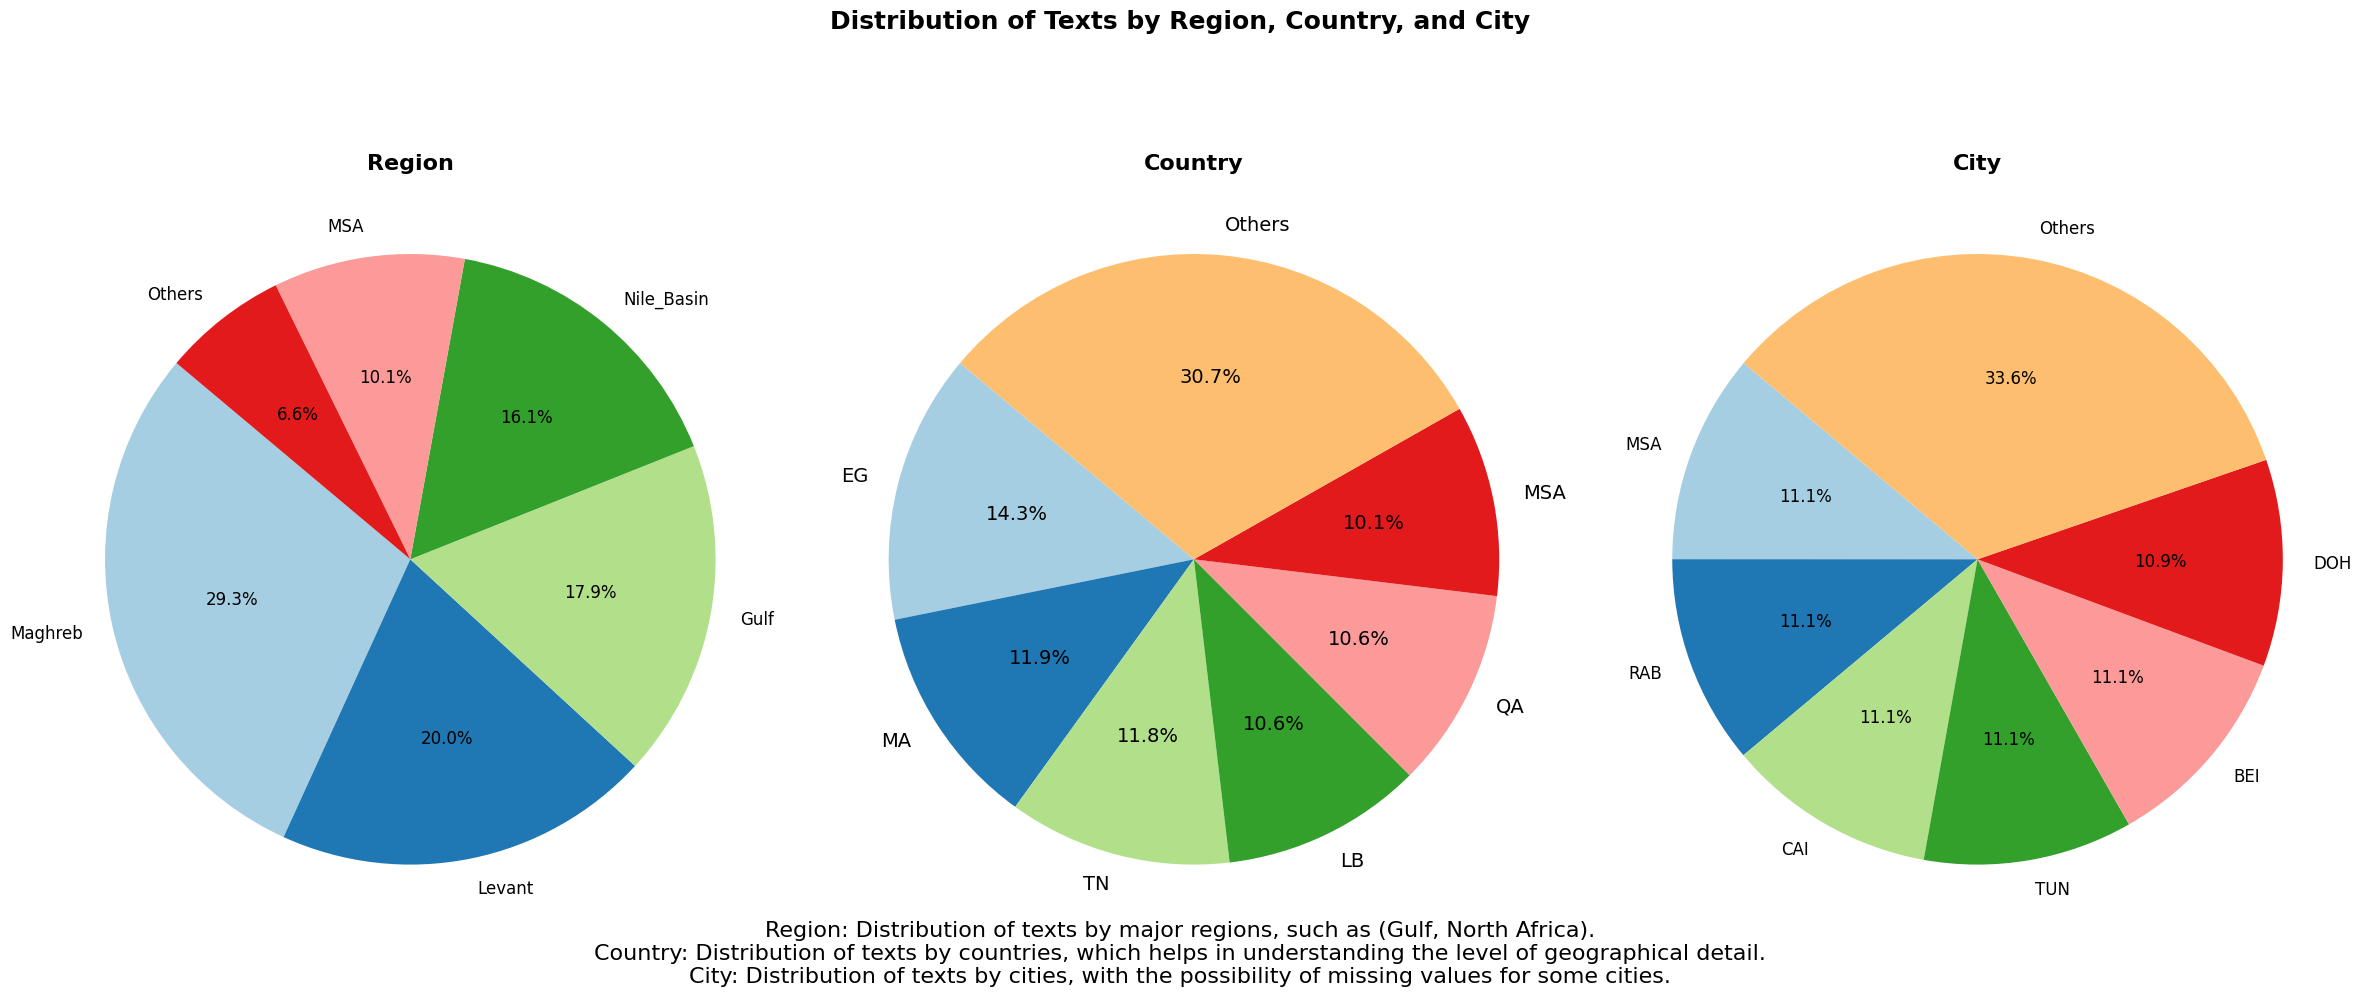

In [ ]:
colors_region = plt.cm.Paired(range(len(region_counts)))
colors_country = plt.cm.Paired(range(len(country_counts)))
colors_city = plt.cm.Paired(range(len(city_counts)))

fig, axes = plt.subplots(1, 3, figsize=(24, 10))
fig.suptitle("Distribution of Texts by Region, Country, and City", fontsize=18, fontweight='bold')

#Region Pie Chart
axes[0].pie(
    region_counts,
    labels=region_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 12},
    colors=colors_region
)
axes[0].set_title("Region", fontsize=16, fontweight='bold')

#Country Pie Chart
axes[1].pie(
    country_counts,
    labels=country_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 14},
    colors=colors_country
)
axes[1].set_title("Country", fontsize=16, fontweight='bold')

#City Pie Chart
axes[2].pie(
    city_counts,
    labels=city_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 12},
    colors=colors_city
)
axes[2].set_title("City", fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.9])

annotations = (
    "Region: Distribution of texts by major regions, such as (Gulf, North Africa).\n"
    "Country: Distribution of texts by countries, which helps in understanding the level of geographical detail.\n"
    "City: Distribution of texts by cities, with the possibility of missing values for some cities."
)
plt.figtext(0.5, 0.01, annotations, ha='center', fontsize=16, wrap=True)

plt.show()

<div dir = 'rtl'>
ملاحظات حول المخططات السابقة:
</div>
<div dir = 'rtl'>
المناطق مثل المغرب العربي تحتوي على نسبة كبيرة من النصوص، مما يشير إلى تركز البيانات في أماكن معينة.
</div>
<div dir = 'rtl'>
كما أن هناك الكثير من المدن والدول التي تملك نسب قليلة جدا (أقل من 5%) والتي نراها في فئة others
</div>
<div dir = 'rtl'>
وبالتالي نرى التوزيع ليس متوازنا بشكل كبير.
</div>

## [2.2] Tokenization

<div dir = 'rtl'>
تقسيم النص إلى كلمات (tokenization)، ثم طباعة أول 5 أسطر بعد التقسيم
و حساب عدد الكلمات الكلي (total tokens)  وعدد الكلمات الفريدة الكلي .
</div>

<div dir = 'rtl'>
تم تقسيم النص باستخدام مكتبة pyarabic .
</div>
<div dir = 'rtl'>من مزاياها:</div>
<div dir = 'rtl'>

*   مخصصة بالكامل لمعالجة اللغة العربية.

*   سهولة في استخدام الوظائف المتعلقة بالنصوص العربية مقارنة بـ NLTK.
*   دعم قوي للخصائص الفريدة للغة العربية مثل الأحرف، الحركات، التشكيل، والأوزان.
*   توفير أدوات لمعالجة النصوص العربية، مثل التقطيع (Tokenization)، إزالة التشكيل (Diacritics)، والتعامل مع الكلمات المركبة.
</div>

In [ ]:
def tokenize_column(df, column_name):

    df[f"{column_name}_tokens"] = df[column_name].apply(tokenize)
    return df

In [ ]:
tokenize_column(final_train_df, 'text').head()

,text,Country,Region,City,text_tokens
0,@A_E_92 استاذ عبدالعزيز صارله الموضوع سنه يعن...,KW,Gulf,None,"[@, A_E_92, استاذ, عبدالعزيز, صارله, الموضوع, ..."
1,#كذبة_نيسان كل عام والكذاب بألف خير 🙈😂 https:/...,JO,Levant,None,"[#, كذبة_نيسان, كل, عام, والكذاب, بألف, خير, 🙈..."
2,@basitooo5 طمطم عاااتى طبق جبنة 🙄,EG,Nile_Basin,None,"[@, basitooo5, طمطم, عاااتى, طبق, جبنة, 🙄]"
3,@alsyasiyeh @alsyaaf يمكن متلاحقين السوق بيشتر...,AE,Gulf,None,"[@, alsyasiyeh, @, alsyaaf, يمكن, متلاحقين, ال..."
4,@A_A_AlTammar عيل المدرب حمار حشاك .. مالها حل...,KW,Gulf,None,"[@, A_A_AlTammar, عيل, المدرب, حمار, حشاك, ..,..."


In [ ]:
all_tokens = [word for tokens in final_train_df['text_tokens'] for word in tokens]
total_tokens = len(all_tokens)
unique_tokens = len(set(all_tokens))

print("First 5 rows after tokenization:\n", final_train_df[['text_tokens']].head())
print("\nNumber of total tokens:", total_tokens)
print("Number of vocabs (unique tokens):", unique_tokens)

First 5 rows after tokenization:
                                          text_tokens
0  [@, A_E_92, استاذ, عبدالعزيز, صارله, الموضوع, ...
1  [#, كذبة_نيسان, كل, عام, والكذاب, بألف, خير, 🙈...
2         [@, basitooo5, طمطم, عاااتى, طبق, جبنة, 🙄]
3  [@, alsyasiyeh, @, alsyaaf, يمكن, متلاحقين, ال...
4  [@, A_A_AlTammar, عيل, المدرب, حمار, حشاك, ..,...

Number of total tokens: 843751
Number of vocabs (unique tokens): 95159


## [2.3] Word Cloud

<div dir = 'rtl'>
لرسم word cloud لكلمات باللغة العربية يجب استخدام عدة امور:
</div>
<div dir = 'rtl'>

*    مكتبة arabic_reshaper لإعادة تشكيل النصوص العربية بحيث تكون الحروف متصلة بشكل صحيح.
*   مكتبة bidi.algorithm.get_display تعيد ترتيب النصوص لتظهر بشكل صحيح في الـ Word Cloud.
*   يجب استخدام خط يدعم اللغة العربية.
</div>

In [ ]:
def column_to_wordcloud(df, column, stopwords):

    all_words = ' '.join([' '.join(tokens) for tokens in df[column]])

    all_words = re.sub(r'[^\w\s\u0600-\u06FF]', '', all_words)

    text = arabic_reshaper.reshape(all_words)
    # create and display the wordcloud
    wordcloud = WordCloud(font_path='/content/drive/My Drive/noto-naskh-arabic/static/NotoNaskhArabic-Regular.ttf',
                          width=3500, height=2000, random_state=1, background_color='white',
                          colormap='Set2', collocations=False,
                          stopwords = stopwords).generate(text)

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

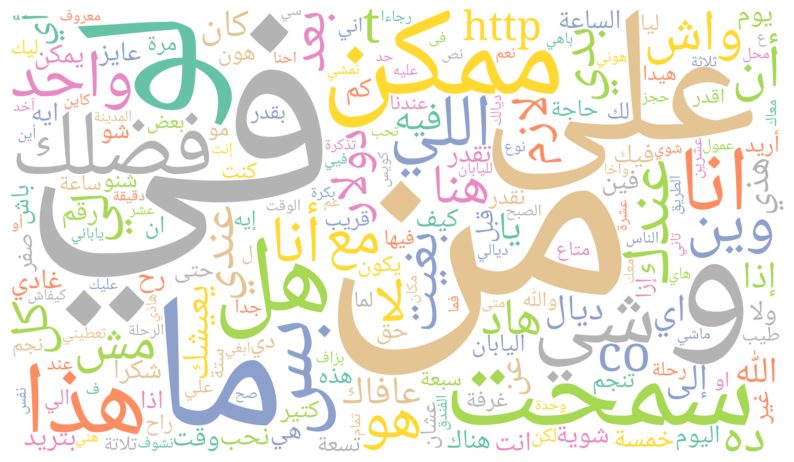

In [ ]:
column_to_wordcloud(final_train_df, 'text_tokens', [])

<div dir = 'rtl'>
نلاحظ ان أكثر الكلمات وروداً هي عبارة عن أحرف وضمائر، وبالتالي يجب حذف ال stopwords.
</div>

In [ ]:
path = '/content/drive/My Drive/FINAL_DATASET/arabic_dialects_stopwords.csv'
stopwords = pd.read_csv(path)["word"].tolist()
stopwords = [arabic_reshaper.reshape(s) for s in stopwords]
print(len(stopwords))

1997


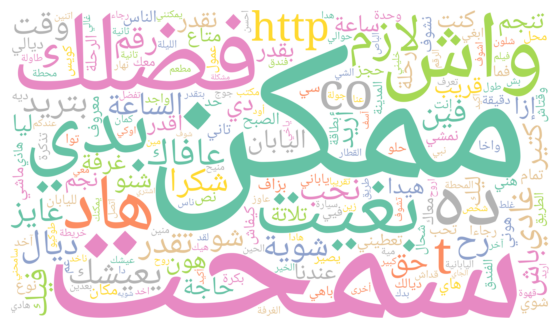

In [ ]:
column_to_wordcloud(final_train_df, 'text_tokens', stopwords)

## [2.4] Analyze tokenized text

<div dir = 'rtl'>
التابع التالي يقوم بأخذ النص المقطّع وإجراء بعض التحليلات عليه.
</div>
<div dir = 'rtl'>
مثلا يقوم بإيجاد أكثر الثنائيات المكررة كالتالي:

*   يتم إنشاء ثنائيات الكلمات باستخدام دالة bigrams من مكتبة NLTK.
*   يتم حساب تكرار كل ثنائي باستخدام مكتبة Counter.

*   يتم استخراج الثنائيات الأكثر تكرارًا باستخدام دالة .most_common(n).
</div>
<div dir = 'rtl'>
وتم إيجاد أكثر الثلاثيات المكررة بنفس الطريقة مع تغيير بالتوابع.

</div>
<div dir = 'rtl'>
طريقة إيجاد الكلمات المهمة (Collocations):


*  Collocations هي أزواج أو مجموعات من الكلمات التي تظهر معًا بشكل متكرر في السياق أكثر مما يُتوقع بالصدفة.
*   يتم استخدام BigramCollocationFinder من مكتبة NLTK للعثور على ثنائيات الكلمات المهمة.
*   يتم تجاهل الثنائيات أو الثلاثيات التي تحدث مرة واحدة لأنها غالبًا لا تحمل دلالة قوية.
*   يتم تحديد الثنائيات الأكثر أهمية بناءً على مقياس إحصائي  PMI (Pointwise Mutual Information).

</div>
<div dir = 'rtl'>
مقياس PMI:  
</div>
<div dir = 'rtl'>
يقوم بحساب احتمالات الكلمات والثنائيات من خلال الصيغة التالية:
</div>

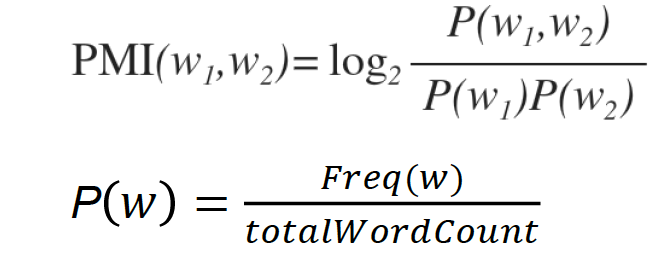

<div dir = 'rtl'>
حيث:


*   P(w1,w2) هو احتمال ظهور الثنائي
(
𝑤
1
,
𝑤
2
)
 معًا.
*   P(w1) و
𝑃
(
𝑤
2
)
 هما احتمالات ظهور الكلمات الفردية.
</div>

In [ ]:
def analyze_tokenized_text(data, level, n):

    print(f"\n{'-'*50}\nتحليل المستوى: {level}\n{'-'*50}")


    level_data = data.groupby(level)['text_tokens'].sum()

    for category, tokens in level_data.items():
        print(f"\nتحليل الفئة: {category}\n")

        # most common words
        word_counts = Counter(tokens)
        most_common_words = word_counts.most_common(n)

        # hapaxes
        hapaxes = [word for word, count in word_counts.items() if count == 1][:n]

        # most common bigrams
        bigrams = list(zip(tokens, tokens[1:]))
        bigram_counts = Counter(bigrams)
        most_common_bigrams = bigram_counts.most_common(n)

        # most common trigrams
        trigrams = list(zip(tokens, tokens[1:], tokens[2:]))
        trigram_counts = Counter(trigrams)
        most_common_trigrams = trigram_counts.most_common(n)

        # Collocations Bigram
        bigram_finder = BigramCollocationFinder.from_words(tokens)
        bigram_finder.apply_freq_filter(2)
        collocations_bigrams = bigram_finder.nbest(BigramAssocMeasures.pmi, n)

        # Collocations Trigram
        trigram_finder = TrigramCollocationFinder.from_words(tokens)
        trigram_finder.apply_freq_filter(2)
        collocations_trigrams = trigram_finder.nbest(TrigramAssocMeasures.pmi, n)

        print(f"Most {n} common words: {', '.join([word for word, _ in most_common_words])}")
        print(f"{n} hapaxes: {', '.join(hapaxes)}")
        print(f"Most {n} common bigrams : {', '.join([' '.join(bigram) for bigram, _ in most_common_bigrams])}")
        print(f"Most {n} common trigrams : {', '.join([' '.join(trigram) for trigram, _ in most_common_trigrams])}")
        print(f"Most {n} collocations bigram: {', '.join([' '.join(bigram) for bigram in collocations_bigrams])}")
        print(f"Most {n} collocations trigram: {', '.join([' '.join(trigram) for trigram in collocations_trigrams])}")

<div dir = 'rtl'>
هل ثنائيات وثلاثيات الكلماتت الأكثر تكراًر هي نفسها ال collocations؟
</div>
<div dir = 'rtl'>
اعتمادا على التابع السابق وآلية إيجاد كل منها، نستنتج التالي:
</div>
<div dir = 'rtl'>
بالنسبة للثنائيات والثلاثيات الأكثر تكرارًا:


*   تعتمد فقط على عدد مرات ظهور الكلمات معًا في النص.
*  يمكن أن تكون تكرارات عشوائية أو نتيجة لجملة معينة تُكرر عدة مرات.
</div>
<div dir = 'rtl'>
أما الكلمات المهمة Collocations:


*   تعتمد على مدى احتمالية ارتباط الكلمات في السياق، وليس فقط التكرار.
*  يمكن أن تحتوي على كلمات ليست الأكثر تكرارًا، لكنها تظهر معًا بشكل دالّ.
</div>
<div dir = 'rtl'>
وبالتالي: الثنائيات والثلاثيات الأكثر تكرارًا ليست دائمًا هي نفسها الـ Collocations، Collocations تعتمد على العلاقات الإحصائية بين الكلمات، بينما الأكثر تكرارًا يعتمد فقط على العدد.
</div>

In [ ]:
analyze_tokenized_text(final_train_df, 'Region', 10)


--------------------------------------------------
تحليل المستوى: Region
--------------------------------------------------

تحليل الفئة: Gulf

Most 10 common words: ., ؟, ،, @, في, من, لو, سمحت, على, ما
10 hapaxes: A_E_92, صارله, اراجع, التامينات, متلاحقين, للغداء, A_A_AlTammar, حشاك, الاحتمال, واااارد
Most 10 common bigrams : لو سمحت, ، لو, سمحت ., . ممكن, :// t, t ., . co, co /, https ://, . لو
Most 10 common trigrams : ، لو سمحت, لو سمحت ., :// t ., t . co, . co /, https :// t, . لو سمحت, لو سمحت ؟, ؟ لو سمحت, . ممكن تعطيني
Most 10 collocations bigram: ابغيكم تنتبهون, البالوعة مسدودة, السوشل ميديا, المحادثة الانجليزية, باليمين وباليسار, ستيت بيلدينج, سنسناتي ريدز, فيفث افينيو, قولدن قيت, مايهذري المهذري
Most 10 collocations trigram: للاحتفال بذكرى تأسيس, جسر قولدن قيت, العاب نارية لكندا, لنيو أورلينز بتتأخر, بذكرى تأسيس الدستور, سدادة حوض الاستحمام, 7oor_1234 يسعد صباحج, العيش وشوربة الميسو, كوسيز لاف "؟, & lt ;

تحليل الفئة: Iraqi

Most 10 common words: ., ؟, ،, هذا, من, رجاءا, م

In [ ]:
analyze_tokenized_text(final_train_df, 'Country', 10)


--------------------------------------------------
تحليل المستوى: Country
--------------------------------------------------

تحليل الفئة: AE

Most 10 common words: @, من, 
, ., .., ما, الله, و, /, اللي
10 hapaxes: متلاحقين, السوق, بيشترون, سمك, للغداء, 😋, UAENSR, سمعا, وطاعه, مانوفيك
Most 10 common bigrams : :// t, t ., . co, co /, https ://, شاء الله, 😂 @, ان شاء, كل شي, http ://
Most 10 common trigrams : :// t ., t . co, . co /, https :// t, ان شاء الله, http :// t, gt ;& gt, الله يبارك فيك, ؟ https ://, … http ://
Most 10 collocations bigram: السوشل ميديا, باليمين وباليسار, كامل &, 7oor_1234 يسعد, يبيع ابوه, يسعد صباحج, فترة طويله, كرة القدم, M_A_ALMULLA هههههههه, & gt
Most 10 collocations trigram: 7oor_1234 يسعد صباحج, كامل & gt, الموضوع كامل &, شاهد الموضوع كامل, & gt ;&, ;& gt ;, فترة طويله جداً, gt ;& gt, ;& gt ;&, قسمة و نصيب

تحليل الفئة: BH

Most 10 common words: @, 
, من, ., في, ما, .., /, ://, t
10 hapaxes: الهُم, عفو, كريم, تُحب, فأعفُ, عنا, Brazzo, حسن, عطنا, باقلة
Most

<div dir='rtl'>
سيتم تطبيق التحليل على المستوى المدينة على بيانات MADAR فقط، ولذلك لعدم وجود المدينة في QADI
</div>

In [ ]:
tokenize_column(madar_train_final, 'text')
analyze_tokenized_text(madar_train_final, 'City', 10)


--------------------------------------------------
تحليل المستوى: City
--------------------------------------------------

تحليل الفئة: ALE

Most 10 common words: ., ؟, ،, إذا, سمحت, بدي, ما, من, خرج, رح
10 hapaxes: معلومات, السياح, سمعان, بهالعنوان, كريمة, بقهوتك, تصرفلي, الميتين, الكافيه, اطفال
Most 10 common bigrams : إذا سمحت, ، إذا, سمحت ., . بدي, ؟ بدي, . خرج, . إذا, . رح, . في, . وين
Most 10 common trigrams : ، إذا سمحت, إذا سمحت ., . إذا سمحت, إذا سمحت ؟, . في شي, ؟ إذا سمحت, ؟ طيب ،, . نعم ،, . أوه ،, . لا ،
Most 10 collocations bigram: التصريح الجمركي, الحي الصيني, بالتوقيت المحلي, بشتغل بشركة, حديقة الحيوانات, عطلة وطنية, فنادق رخيصة, لاس فيغاس, لوس أنجلس, انتبه عالحفرة
Most 10 collocations trigram: القطار لحتى أوصل, أدق مكالمة خارجية, انسرقت مني شنتايتي, عند تالت مفرق, الطرف تبعك عالخط, ايه بي سي, الخطوط الجوية اليابانية, بطاقتين درجة تانية, أشتري هدايا تذكارية, هو عطلة وطنية

تحليل الفئة: ALG

Most 10 common words: ., ؟, ،, من, فضلك, راني, حاب, و, اذا, تقدر
10 hapaxes: مع

<div dir='rtl'>
نلاحظ التالي:


*   وجود الكثير من الإيموجيز والرموز والإشارات والارقام الغير ضرورية.

*   وبالتالي تؤثر بشكل كبير على تشكيل الثنائيات والثلاثيات.
*   وبذلك نرى ان النص بحاجة لعمليات تنظيف.

*   إثباتا لما ذكرناه في الخلايا السابقة، فإن الثنائيات والثلاثيات الاكثر تكراراً ليست نفسها ال collocations.
</div>

## [2.5] Find unique words by dialect

<div dir = 'rtl'>
التابع التالي يقوم بإيجاد الكلمات المميزة في كل لهجة.
</div>
<div dir = 'rtl'>
حيث دخل التابع: الداتا فريم، مستوى التحليل (Region, Country, City)، الحد الأدنى لتكرار الكلمة حتى تعتبر فريدة
</div>

In [ ]:
def find_unique_words_by_dialect(data, level, min_freq):

    unique_words_per_category = {}

    level_data = data.groupby(level)['text_tokens'].sum()

    level_data = level_data.apply(lambda x: x if isinstance(x, list) else list(x))

    category_word_counts = {category: Counter(tokens) for category, tokens in level_data.items()}

    all_words = set(word for tokens in level_data for word in tokens)
    for category, word_counts in category_word_counts.items():
        other_categories = set(category_word_counts.keys()) - {category}
        other_words = set(word for other_category in other_categories for word in category_word_counts[other_category].keys())

        unique_words = {word: count for word, count in word_counts.items()
                        if word not in other_words and count >= min_freq}

        unique_words_per_category[category] = dict(sorted(unique_words.items(), key=lambda x: x[1], reverse=True))

    return unique_words_per_category

In [ ]:
#Unique words by Region
unique_words_region = find_unique_words_by_dialect(final_train_df, 'Region', 10)

print("\nThe unique words by Region:")
for region, words in unique_words_region.items():
    print(f"{region}: {', '.join(words.keys())}")


The unique words by Region:
Gulf: أبا, ابغى, مسامحة, شكثر, انزين, وايد, ابغا, جذي, صج, خلني, مادري, شرايك, تبا, أبغا, خلنا, الدريشة, اهني, امش, رفيجي, برع, غرشة, بجم, هذيلا, سيده, استانست, بوكي, بتم, الريوق, يرجى, تحاتي, انجيلوس, طرش, وعقب, hassanalishaq73, نبا, هالشناط, اتم, تبغا, حياك, جدام, ماظن, الجيك, ابغيك, صدقت, والحين, بسوي, تطرش, يدري, تركي_اهبط_الاتحاد20, باخذه, لليأبان, كويتي, ربعي, قصرت, برقر, الكنديشن, تألمني, تبتدي, يبتدي, هالطرد, Almajlliss, الانتر, الصج, يشتغلون, همبرقر, مابغي, باللهي
Iraqi: اكدر, غاح, اغيد, اطيق, اشقد, احنه, ويحد, تطيق, اتطيق, انطيني, شوكت, كولش, اشون, كثيغ, يمته, هنوك, تغيد, اغوح, ايمتي, اللخ, تلث, تنطيني, بلية, جانت, فد, تكلي, الجنط, تكولي, رجائا, هوايه, قغيب, نكدر, رخصتك, عدنه, اشتغي, اللك, جنطتي, هيج, جنت, جنطة, الجنطة, خمسي, عدكم, الريوك, كهوة
Levant: بتريد, إزا, هيدا, عمول, هلأ, عاليابان, رأم, وأت, تمانة, إخد, فرجيني, هدول, إلك, تبعي, شكرًا, لهونيك, تنان, مبارح, لهون, بعتئد, بعتقد, بعتزر, مصاري, ازا, إحجز, بدها, تفرجيني, ايمتى, إزنك, المصاري, بي

In [ ]:
#Unique words by country
unique_words_country = find_unique_words_by_dialect(final_train_df, 'Country', 5)

print("\nThe unique words by Country:")
for country, words in unique_words_country.items():
    print(f"{country}: {', '.join(words.keys())}")


The unique words by Country:
AE: 
BH: تركي_اهبط_الاتحاد20, عبدالعزيز_الرويحي, alzeen1122333, Manama9200Ahmed, AL_JALAL2000
DZ: تع, دوكا, صحا, لوكان, وعلاش, 012869945mmmmm1, الدراهم, ممبعد, سنابات_غازي_المطيري, AwaTefDz_23, rsedkzd4, SouihatKhaled, بالاك, نفرحو, ويدا, تصيب, دياولك
EG: إزاي, متهيألي, جامد, علطول, مؤاخذة, هاخد, أيوه, دلوقتى, إزاى, بتاعى, ترابيزة, اوضه, الاتوبيس, حاخد, الفطار, الاوضه, إديني, بتاعتى, اوتوبيس, اتوبيس, أوضه, أوى, اوضة, متشكر, أوكى, قوللي, لمؤاخذة, تربيزة, ترشحلي, أنهى, هايبقى, هيكون, حتة, بالطو, أزاي, هيبقى, بأدور, الاوتوبيس, إدينى, تقوللى, بأحب, جه, ازيك, تملا, بادور, ترابيزه, هكون, يافندم, تقولى, هتلاقيه, كوباية, اوضتي, اتنقل, بتاعتنا, أقف, هايكون, أفتكر, أنهو, الاخوان, دماغك, كوبايه, البالطو, استلف, أسيب, أستلف, كرسى, خلينى, الزمالك, عايزك, ماية, ازاى, بشويش, حأرجع, هايبر, فطار, أوضتى, الكرسى, متهيئلي, هيً, اوى, مستني, النهارده, جالي, أزيك, املى, الاسانسير, أحود, أزاى, جاى, بيقف, إزازة, إزيك, هروح, هنوصل, معرفش, مصريين, عادى, لحضرتك, الستات, المهمه, بقالك

In [ ]:
#Unique words by City
unique_words_city = find_unique_words_by_dialect(madar_train_final, 'City', 5)

print("\nThe unique words by City:")
for city, words in unique_words_city.items():
    print(f"{city}: {', '.join(words.keys())}")


The unique words by City:
ALE: إيمت, هلئ, مشان
ALG: تع, صحا, دوكا, لوكان, لهاذ, وعلاش, ممبعد, تاع, الدراهم, ويدا, تصيب, فالحين, ارواح, دياولك
ALX: الجاى, إمشى, صاحبى, تيجى, قوللى, معدتى
AMM: إشي, أشيك
ASW: متهيئلي, هيً, آجر, عندينا, إنهاردة, هبقى
BAG: كولش, بلية, تكولي, رجائا, هوايه, بليه
BAS: يمته, راويني, ببيش, الشباج
BEI: هيدا, عمول, رأم, وأت, إخد, شكرًا, لهونيك, هلق, تنان, بعتئد, بعتزر, إحجز, بعتقد, ايمتى, إزنك, بطاءة, إستاذ, يسلمو, مطرح, تئلي, هودي, أيمتا, بفتكر, إشتري, جايي, أريب, إستاز, مأعد, إستأجر, حكيم, عنيويورك, بهيدا, أمتين, شنطاتي, زغيرة, فتش, إدفع, لائي, بطاءات, أأرب, عشيكاغو, هيداك, عتاني, عأوتيل, نطور, كلن, عبوسطن, فإزًا, دئايئ, الرأم, الترويقة, بروم, ديقة, إستعير, لايحة, عمكتب, التياب, تكت, عندكن, بالترين, أهوة, أولك, إطلب, ميتان, كرمال, عأي, عسان, عكل, تعتل, إحكي, موأف, دئيئة, عوسط, عمنبش, تياب, شتريت, أبدًا, أزغر, مطارح, علوس, إبئا, مأعدين, ورأم, الحكيم, شرشف, الجايي, كفي, تماني, خمستعشر, ببلش, إبقى, عمفتش, عباريس, لإنو, بهالوقت, عالأوضة, أدار, لهيدا, الشنطات, عهيدا

<div dir = 'rtl'>
بعض الملاحظات بناء على النتاءج السابقة:


*   نلاحظ كمثال وجود الكلمتين (اشتي, أشتي) في مستوى Yemen، فوهما نفس الكلمتين ولكن باختلا الهمزة على الألف.

*  هناك كلمات لها نفس المعنى، مثل (ابغى, نبغى) في مستوى RIY.
*   كما أن هناك كلمات متشابهة بين مدينتين مثلا كلمة (أبغا) في مدينة MUS وكلمة (ابغى) في مدينة RIY، مع اختلاف شكل الالف اخر الكلمة فقط.

*   وبالتالي يجب عمل normalize لحرف الالف أثناء عمليات التنظيف.
*   بالنسبة للتشكيل فمن الملاحظ أن تنوين النصب والشدة الاكثر استخداما، وبالتالي لا يوجد تاثير كبير له أو تغيير في المعنى، فيمكن الاستغناء عن التنوين في عمليات التنظيف، لكن الشدة غالبا ما تعطي معنى.

*   يوجد الكثير من التكرارات في الاحرف بالإضافة لبعض الارقام، والتي من الأفضل التخلص منها.

*   معظم الكلمات الانجليزية الموجودة عبارة عن اسماء مستخدمين، وبالتالي ليس هناك أي فائدة منهم في التحليل.
*   أخيرا، من الواضح أنه كل ما كبر مستوى التحليل، قلّ عدد الكلمات المميزة.
</div>

## [2.6] Calculate similarity

<div dir='rtl'>
إنشاء مصفوفة التشابه بين اللهجات بناءً على الكلمات الفريدة لكل مستوى.
</div>
<div dir='rtl'>
تم استخدام معامل Jaccard لقياس التشابه بين مجموعات الكلمات.
</div>
<div dir='rtl'>
وهو مقياس يستخدم لقياس درجة التشابه أو الاختلاف بين مجموعتين  بغض النظر عن عدد مرات التكرار. يتم تعريفه على النحو التالي:
</div>

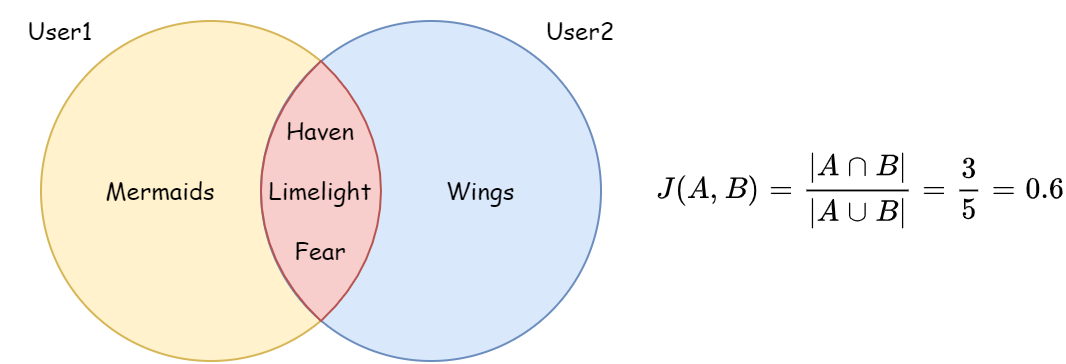

<div dir='rtl'>
حيث:


*   إذا كانت
𝐴
 و
𝐵
 متطابقتين تمامًا: يكون
𝐽
(
𝐴
,
𝐵
)
=
1
.
*   إذا كانت
𝐴
 و
𝐵
 غير متقاطعتين تمامًا: يكون
𝐽
(
𝐴
,
𝐵
)
=
0
.
*   القيمة تقع بين
0
 و
1
: كلما اقتربت القيمة من
1
، زادت درجة التشابه.
</div>
<div dir='rtl'>
ملاحظة: تم تجريب cosine similarity لكن jaccard أعطى نتائج أدق
</div>

In [ ]:
def calculate_similarity_matrix(data, level):

    grouped = data.groupby(level)['text_tokens'].sum()

    unique_words_per_level = grouped.apply(set)
    labels = unique_words_per_level.index.tolist()

    num_levels = len(labels)
    similarity_matrix = np.zeros((num_levels, num_levels))

    for i in range(num_levels):
        for j in range(num_levels):
            if i == j:
                similarity_matrix[i, j] = 1.0
            else:
                # calculate Jaccard Index
                intersection = len(unique_words_per_level.iloc[i] & unique_words_per_level.iloc[j])
                union = len(unique_words_per_level.iloc[i] | unique_words_per_level.iloc[j])
                similarity_matrix[i, j] = intersection / union

    return similarity_matrix, labels

<div dir='rtl'>
إنشاء خريطة حرارية (Heatmap) لعرض تقارب أو اختلاف اللهجات بناءً على مصفوفة التشابه.
</div>

In [ ]:
def plot_heatmap(matrix, labels, title):

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, cmap="coolwarm", annot=True, fmt=".2f")
    plt.title(title)
    plt.show()

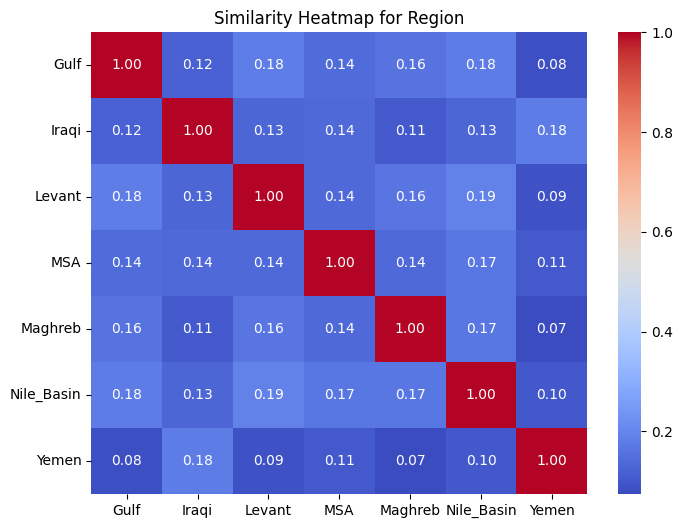

In [ ]:
#Region HeatMap
similarity_matrix, labels = calculate_similarity_matrix(final_train_tokenization, 'Region')
plot_heatmap(similarity_matrix, labels, f"Similarity Heatmap for {'Region'.capitalize()}")

<div dir='rtl'>
نلاحظ ان اعلى نسبة تشابه هي 0.19 بين Levant (بلاد الشام) و Nile_Basin (حوض النيل).
</div>
<div dir='rtl'>
وأقل نسبة تشابه هي 0.07 بين Yemen (اليمني) و Maghreb (المغاربية).
</div>

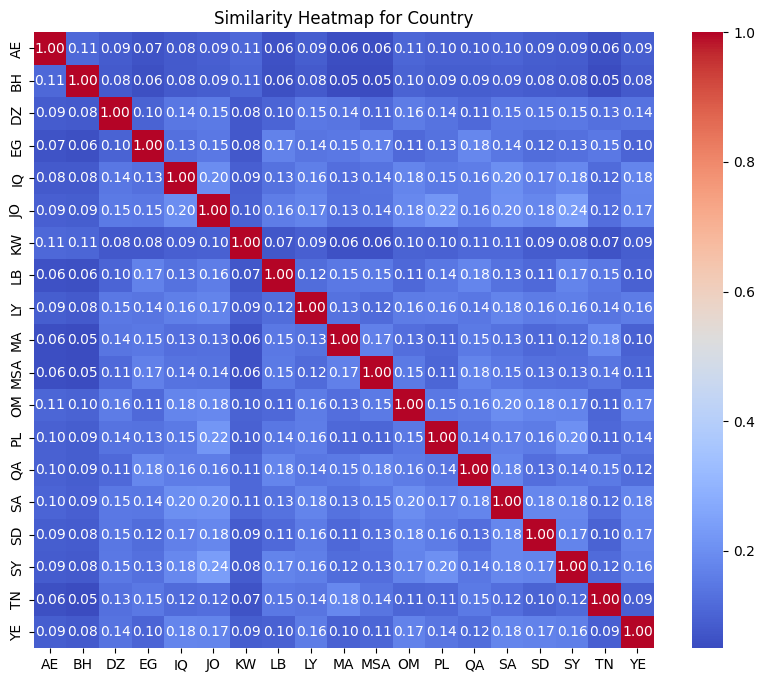

In [ ]:
#Country HeatMap
similarity_matrix, labels = calculate_similarity_matrix(final_train_tokenization, 'Country')
plot_heatmap(similarity_matrix, labels, f"Similarity Heatmap for {'Country'.capitalize()}")

<div dir='rtl'>
  اعلى نسبة تشابه هي 0.24 بين JO (الاردن) و SY (سوريا)وهما في نفس المنطقة.
</div>
<div dir='rtl'>
وأقل نسبة تشابه هي 0.009 بين BH (البحرين) و SA (السعودية) وهما أيضا في نفس المنطقة، بالإضافة لوجود نفس النسبة بين عدة دول اخرى.
</div>
<div dir='rtl'>
وبالتالي نسب التشابه على مستوى الدول أقل منه على مستوى المناطق.
</div>

<div dir='rtl'>
بالنسبة للمدن سنقوم برسم Network Graph لتمثيل التقارب، لأن عدد المدن كبير ولن يكون واضح من خلال ال heatmap.
</div>
<div dir='rtl'>
حيث سيتم تمثيل المدن كعقد (Nodes) والروابط بينها بناءً على التشابه.
</div>


In [ ]:
import networkx as nx

def plot_network(matrix, labels, threshold):

    graph = nx.Graph()

    graph.add_nodes_from(labels)

    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            if matrix[i, j] >= threshold:
                graph.add_edge(labels[i], labels[j], weight=matrix[i, j])

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=2000, font_size=10)
    plt.title("City Similarity Network")
    plt.show()


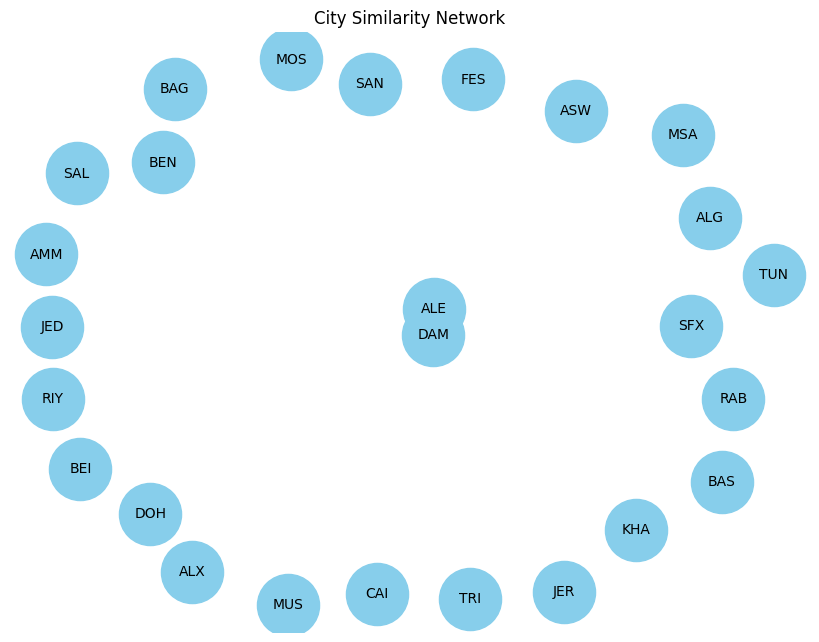

In [ ]:
similarity_matrix, labels = calculate_similarity_matrix(madar_train_final, 'City')
plot_network(similarity_matrix, labels, 0.388)

<div dir='rtl'>
  نلاحظ التقارب الكبير بين ALE (حلب) و DAM (دمشق)، وهذه نتيجة دقيقة.
</div>
<div dir='rtl'>
كما نلاحظ ان هناك تقارب بين SFX (صفاقس) و TUN (تونس) وهما مدينتان في محافظة تونس، وهما متباعدتان عن SAN (صنعاء) وهي يمنية، وهذه النتائج مطابقة لل heatmap السابقة ، حيث كانت نسبة التشابه بين تونس واليمن أقل نسبة (0.09).
</div>

<div dir = 'rtl'>
سنقوم بإجراء تحليل المجموعات (Clustering) أيضا، وذلك بتطبيق خوارزمية  Hierarchical Clustering لتجميع اللهجات المتشابهة.
</div>
<div dir = 'rtl'>
نستخدم خوارزمية Agglomerative Clustering مع اختيار مسافة التشابه Euclidean.
</div>
<div dir = 'rtl'>
ثم سنقوم برسم مخطط Dendrogram لتصور المجموعات الناتجة.
</div>

In [ ]:
def apply_hierarchical_clustering(similarity_matrix, labels, level_name):

    distance_matrix = 1 - similarity_matrix

    linked = linkage(distance_matrix, method="ward")

    # Plot Dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram(linked, labels=labels, orientation='top', leaf_rotation=90)
    plt.title(f"Hierarchical Clustering for {level_name}")
    plt.xlabel("Clusters")
    plt.ylabel("Distance")
    plt.show()


<ipython-input-31-03de31be20b4>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method="ward")


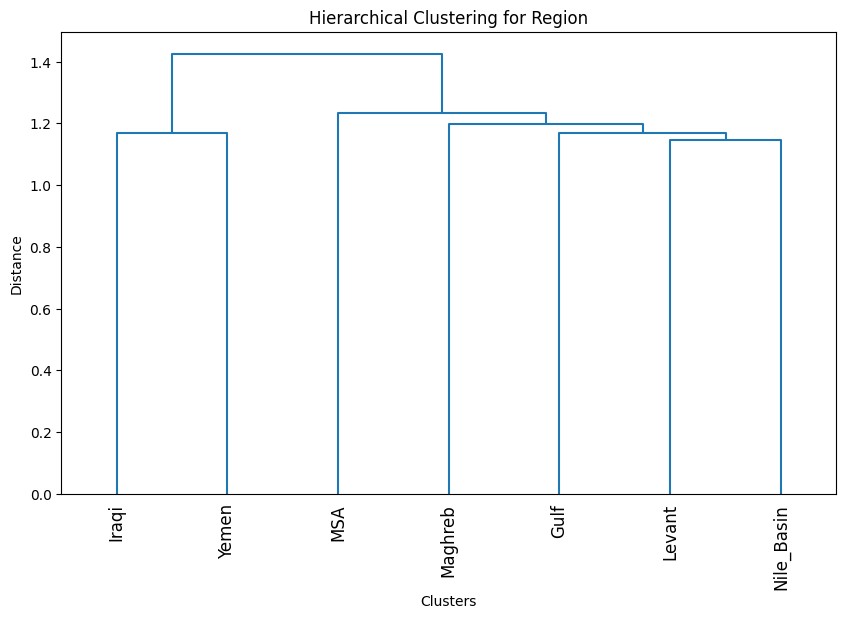

In [ ]:
#Region Dendrogram
region_similarity_matrix, region_labels = calculate_similarity_matrix(final_train_tokenization, "Region")
apply_hierarchical_clustering(region_similarity_matrix, region_labels, "Region")

<ipython-input-31-03de31be20b4>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method="ward")


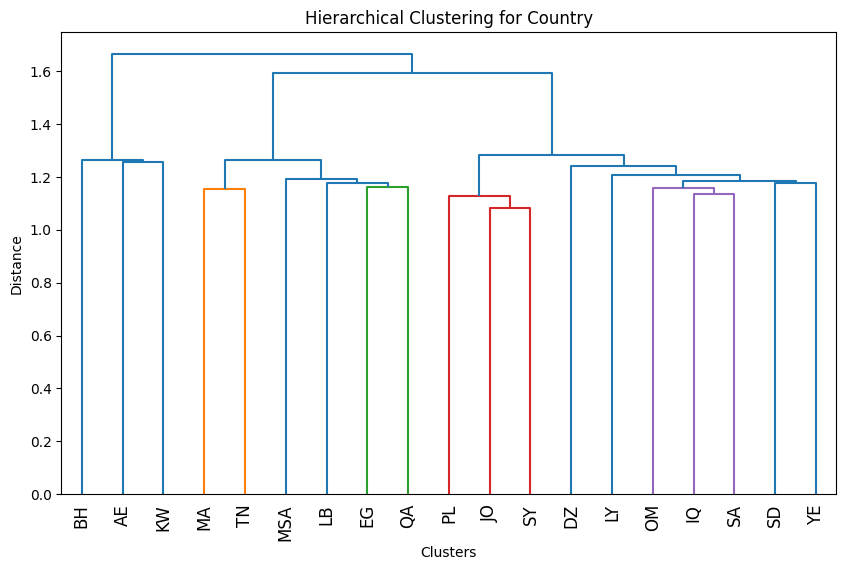

In [ ]:
#Country Dendrogram
country_similarity_matrix, country_labels = calculate_similarity_matrix(final_train_tokenization, "Country")
apply_hierarchical_clustering(country_similarity_matrix, country_labels, "Country")

<div dir='rtl'>
نلاحظ مثلا تجميع مناطق بلاد الشام PL, JO, SY في مجموعة واحدة، وهذه نتيجة جيدة وصحيحة.
</div>

<ipython-input-31-03de31be20b4>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method="ward")


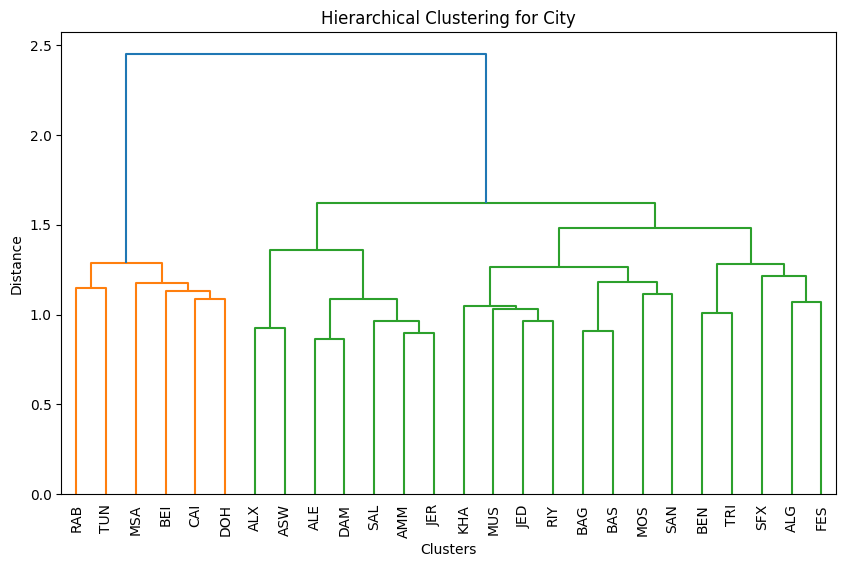

In [ ]:
#City Dendrogram
city_similarity_matrix, city_labels = calculate_similarity_matrix(final_train_tokenization, "City")
apply_hierarchical_clustering(city_similarity_matrix, city_labels, "City")

<div dir='rtl'>
تعقيبا على الاستنتاجات السابقة، نلاحظ تباعد SFX و SAN نوعا ما.
</div>

## [2.7] Models (word2vec, fasttext, glove)

**Install GloVe**

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# GloVe Common Crawl
!wget -c "http://nlp.stanford.edu/data/glove.6B.zip"

!unzip -q glove.6B.zip

# Glove to Word2Vec
glove_input_file = 'glove.6B.300d.txt'
word2vec_output_file = 'glove.6B.300d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

--2025-01-06 08:49:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-01-06 08:49:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-01-06 08:49:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

<ipython-input-35-f37cdaac6723>:12: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


**Intall Word2Vec**

In [ ]:
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


**Install FastText**

In [ ]:
from gensim.models import FastText
from gensim.models import KeyedVectors

# Facebook (FastText Wikipedia)
!wget -c "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz"

fasttext_model = KeyedVectors.load_word2vec_format('cc.ar.300.vec.gz', binary=False)

--2025-01-13 09:53:48--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.67.181.104, 18.67.181.36, 18.67.181.99, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.67.181.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G  80.7MB/s    in 13s     

2025-01-13 09:54:01 (93.7 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]



<div dir = 'rtl'>
OOV (Out of Vocabulary)، وهو مصطلح يشير إلى الكلمات التي لا توجد في مفردات (Vocabulary) النموذج المستخدم لمعالجة النصوص . أي هي الكلمات التي لا يستطيع النموذج التعرف عليها أو تمثيلها باستخدام تضمين الكلمة (Word Embedding).
</div>
<div dir = 'rtl'>
التابع التالي يقوم بحساب نسبة OOV لكل من النماذج التي تم تحميلها مسبقا، يتم حساب النسبة باستخدام الصيغة:
</div>
<div dir = 'rtl'>
$$
OOV Ratio = \frac {Total Tokens − In Vocabulary Tokens}{Total Tokens}
$$
</div>

In [ ]:
# calculate OOV
def calculate_oov(tokens, model):
    vocab = set(model.key_to_index)
    in_vocab = sum(1 for token in tokens if token in vocab)
    total_tokens = len(tokens)
    oov_ratio = (total_tokens - in_vocab) / total_tokens
    return oov_ratio, in_vocab, total_tokens - in_vocab

In [ ]:
all_tokens = [token for tokens in final_train_df['text_tokens'] for token in tokens]

models = {"Word2Vec": word2vec_model, "FastText": fasttext_model, "GloVe": glove_model}
oov_results = {}

for name, model in models.items():
    oov_ratio, in_vocab_count, oov_count = calculate_oov(all_tokens, model)
    oov_results[name] = {
        "OOV Ratio": round(oov_ratio, 4),
        "In Vocabulary": in_vocab_count,
        "Out of Vocabulary": oov_count,
    }

In [ ]:
for name, result in oov_results.items():
    print(f"\n{name} Model:")
    print(f" - OOV Ratio: {result['OOV Ratio']}")
    print(f" - In Vocabulary Count: {result['In Vocabulary']}")
    print(f" - Out of Vocabulary Count: {result['Out of Vocabulary']}")



Word2Vec Model:
 - OOV Ratio: 0.9487
 - In Vocabulary Count: 43304
 - Out of Vocabulary Count: 800447

FastText Model:
 - OOV Ratio: 0.6365
 - In Vocabulary Count: 306714
 - Out of Vocabulary Count: 537037

GloVe Model:
 - OOV Ratio: 0.8527
 - In Vocabulary Count: 124255
 - Out of Vocabulary Count: 719496


<div dir = 'rtl'>
OOV Ratio هو مؤشر يوضح مدى توافق النصوص الجديدة مع مفردات النموذج.
</div>
<div dir = 'rtl'>
بالتالي نسبة OOV المرتفعة تشير إلى أن النموذج قد لا يكون مدربًا جيدًا على نصوص مشابهة لتلك التي يتم تحليلها.
</div>
<div dir = 'rtl'>
من النتائج التي لدينا نلاحظ أن نموذج FastText يعطي أقل نسبة، بالتالي فهو يقلل من مشكلة OOV  لأنه يستخدم تحليل الحروف الجزئية (subwords).
</div>

# مهمة 03 : تنظيف وتوحيد النص

normalization and cleaning Text

## [3.1] cleaning and normalization methods

<div dir='rtl'>
سأقوم بالاستعانة ب  ArSarcasm  وهي ورقة بحثية تقدم طريقة لمعالجة النصوص من وسائل التواصل الاجتماعي (Preprocessing for Social Media Arabic)، حيث سأقوم بتنفيذ خطوات مشابهة يدوياً باستخدام التعابير المنتظمة.
</div>

<div dir='rtl'>
إزالة أسماء المستخدمين (@username):
</div>
<div dir='rtl'>
أسماء المستخدمين ليست مفيدة لتحليل النصوص اللغوية أو التصنيفات، لذا يجب إزالتها.
</div>

In [ ]:
def remove_usernames(text):

    return re.sub(r'@\w+', '', text)

<div dir='rtl'>
إزالة الروابط (URLs):
</div>
<div dir='rtl'>
الروابط لا تضيف أي قيمة تحليلية للنصوص، لذلك يجب التخلص منها.
</div>

In [ ]:
def remove_urls(text):

    return re.sub(r'http\S+|www\.\S+', '', text)


<div dir='rtl'>
إزالة الرموز التعبيرية (Emojis):
</div>
<div dir='rtl'>
الرموز التعبيرية قد تكون مفيدة في تحليل المشاعر، ولكن إذا كان التحليل يركز على النصوص اللغوية فقط، يمكن حذفها.
</div>

In [ ]:
def remove_emojis(text):

    emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U00002500-\U00002BEF"  # chinese char
                              u"\U00002702-\U000027B0"
                              u"\U00002702-\U000027B0"
                              u"\U000024C2-\U0001F251"
                              u"\U0001f926-\U0001f937"
                              u"\U00010000-\U0010ffff"
                              u"\u2640-\u2642"
                              u"\u2600-\u2B55"
                              u"\u200d"
                              u"\u23cf"
                              u"\u23e9"
                              u"\u231a"
                              u"\ufe0f"  # dingbats
                              u"\u3030"
                              "]+", flags=re.UNICODE)
    return emoji_pattern.sub('', text)

<div dir='rtl'>
إزالة الأرقام:
</div>
<div dir='rtl'>
الأرقام قد تكون مفيدة في سياقات معينة مثل تحليل البيانات العددية، لكنها غالبًا غير مفيدة في تحليل النصوص العربية.
</div>

In [ ]:
def remove_numbers(text):

    return re.sub(r'\d+', '', text)

<div dir='rtl'>
إزالة التكرارات الحرفية:
</div>
<div dir='rtl'>
النصوص العامية تحتوي على تكرارات مبالغ فيها للحروف للتعبير عن المشاعر، والتي قد تكون مكررة وغير ضرورية.
</div>

In [ ]:
def normalize_repeated_chars(text):

    return re.sub(r'(.)\1{2,}', r'\1\1', text)

<div dir='rtl'>
إزالة الكلمات غير العربية:
</div>
<div dir='rtl'>
الكلمات غير العربية مثل الاختصارات الإنجليزية أو التعبيرات غير اللغوية لا تفيد التحليل.
</div>

In [ ]:
def remove_non_arabic_words(text):

    return ' '.join([word for word in text.split() if re.search(r'[\u0600-\u06FF]', word)])

<div dir='rtl'>
إزالة المسافات الزائدة:
</div>
<div dir='rtl'>
النصوص غير النظيفة قد تحتوي على مسافات زائدة بين الكلمات.
</div>

In [ ]:
def remove_extra_spaces(text):

    return re.sub(r'\s+', ' ', text).strip()

<div dir='rtl'>
إزالة الهاشتاغات
</div>

In [ ]:
def remove_hashtags(text):

    return re.sub(r'#\w+', '', text).strip()

<div dir='rtl'>
توحيد الألف (أ، إ، آ → ا):
</div>
<div dir='rtl'>
الأحرف "أ"، "إ"، و"آ" تُستخدم لتمثيل الألف في النصوص، ويجب توحيدها إلى "ا".
</div>

In [ ]:
def normalize_alef(text):

    return re.sub(r'[أإآ]', 'ا', text)

<div dir='rtl'>
توحيد الألف آخر الكلمة (ا → ى):
</div>
<div dir='rtl'>
كما وجدنا وجود كلمات مثل (ابغى، ابغا)
</div>

In [ ]:
def normalize_last_alef(text):

    return re.sub(r'[ى]', 'ا', text)

<div dir='rtl'>
توحيد الهاء والتاء المربوطة (ة → ه):
</div>
<div dir='rtl'>
في بعض اللهجات أو السياقات، تُستخدم التاء المربوطة والهاء بشكل متبادل. يمكن توحيدها حسب السياق.
</div>

In [ ]:
def normalize_teh_marbuta(text):

    return re.sub(r'ة', 'ه', text)

<div dir='rtl'>
إزالة علامات التشكيل (الفتحة، الكسرة، الضمة، السكون، الشدة):
</div>
<div dir='rtl'>
التشكيل قد يكون غير مفيد عند تحليل النصوص في المهام التي لا تعتمد على المعنى الصوتي.
</div>

In [ ]:
def remove_tashkeel(text):

    diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

    return diacritics.sub('', text)

<div dir='rtl'>
توحيد النقطة (ى → ي):
</div>
<div dir='rtl'>
النقطة في بعض النصوص اليدوية أو القديمة قد لا تُكتب، لذا يجب توحيد "ى" إلى "ي".
</div>

In [ ]:
def normalize_ya(text):

    return re.sub(r'ى', 'ي', text)

<div dir='rtl'>
إزالة الأحرف الغريبة (رموز غير مفيدة):
</div>
<div dir='rtl'>
الرموز مثل "ـ" تُستخدم أحياناً للتزيين أو التمديد، ويجب إزالتها.
</div>

In [ ]:
def remove_dash(text):

    return re.sub(r'_', ' ', text)

In [ ]:
def remove_extra_chars(text):

    return re.sub('[%s]' % re.escape(
        """!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), '', text)

## [3.2] processing pipeline

In [ ]:
def text_processing_pipeline(text, processing_functions):

    for func in processing_functions:
        if callable(func):
            text = func(text)
        else:
            raise ValueError(f"{func} Unvalid method")
    return text

In [ ]:
processing_pipeline = [
    remove_usernames,
    remove_urls,
    remove_emojis,
    remove_numbers,
    normalize_repeated_chars,
    remove_non_arabic_words,
    remove_extra_spaces,
    remove_hashtags,
    normalize_alef,
    normalize_teh_marbuta,
    remove_tashkeel,
    normalize_ya,
    remove_extra_chars,
    normalize_last_alef,
    remove_dash
]

## [3.3]

In [ ]:
clean_final_train = final_train_df.copy()
clean_final_train['text_tokens'] = final_train_df['text_tokens'].apply(
    lambda x: text_processing_pipeline(' '.join(x), processing_pipeline).split())

In [ ]:
all_tokens = [word for tokens in clean_final_train['text_tokens'] for word in tokens]

total_tokens = len(all_tokens)
unique_tokens = len(set(all_tokens))

print("Number of total tokens:", total_tokens)
print("Number of vocabs (unique tokens):", unique_tokens)

# total tokens befor cleaning : 843751
# vocabs befor cleaning : 95159

Number of total tokens: 663733
Number of vocabs (unique tokens): 75882


<div dir='rtl'>
نلاحظ انخفاض عدد الكلمات الكلية والفريدة بعد التنظيف، وذلك يشير إلى تحسين جودة النصوص وجعلها أكثر تركيزاً.
</div>

## [3.4]

In [ ]:
empty_cells = clean_final_train[clean_final_train['text_tokens'].apply(lambda x: len(x) == 0 or not x)]
clean_final_train = clean_final_train[clean_final_train['text_tokens'].apply(lambda x: len(' '.join(x)) >= 5)]

empty_cells_count = len(empty_cells)
print(f"Number of empty cells: {empty_cells_count}")

removed_rows = clean_final_train[~clean_final_train.index.isin(clean_final_train.index)]
final_train_df.drop(removed_rows.index, inplace=True)

print(f"Number of cells with 4 characters or less: {removed_rows.shape[0]}")

Number of empty cells: 3
Number of cells with 4 characters or less: 0


In [ ]:
clean_final_train.shape
# the shape was = 104,121

(103688, 5)

# مهمة 04  : بناء النموذج المرجعي

Model Baseline

## [4.1] Input vector (X), Target vector (Y)


<div dir='rtl'>
تهيئة البيانات (Extract Features and Labels):


*   شعاع الدخل
𝑋
: يتكون من النصوص الخام.
*   شعاع الهدف
𝑌
: يتكون من تسميات البلدان المرتبطة بكل نص.
</div>

In [ ]:
def extract_features_and_labels(df, text_column, label_column):

    X = df[text_column].tolist()
    Y = df[label_column].tolist()
    return X, Y

In [ ]:
X_train, Y_train = extract_features_and_labels(final_train_df, text_column='text', label_column='Country')
X_val, Y_val = extract_features_and_labels(final_validation_df, text_column='text', label_column='Country')
X_test, Y_test = extract_features_and_labels(final_test_df, text_column='text', label_column='Country')

In [ ]:
print(f"Training Set: {len(X_train)} samples")
print(f"Validation Set: {len(X_val)} samples")
print(f"Test Set: {len(X_test)} samples")

Training Set: 104121 samples
Validation Set: 20349 samples
Test Set: 14179 samples


## [4.2]MultinomialNB_TFIDF

<div dir='rtl'>
تحويل النصوص باستخدام TF-IDF
</div>

In [ ]:
def evaluate_MNB_model(train_df, val_df, text_column, target_column, tfidf_params=0):

    X_train = train_df[text_column]
    X_val = val_df[text_column]

    # TF-IDF
    vectorizer = TfidfVectorizer(**(tfidf_params or {}))

    X_train_tfidf = vectorizer.fit_transform(X_train)
    Y_train = train_df[target_column]

    X_val_tfidf = vectorizer.transform(X_val)
    Y_val = val_df[target_column]

    # Oversampling
    smote = SMOTE(random_state=42)
    X_train_tfidf, Y_train = smote.fit_resample(X_train_tfidf, Y_train)

    #training model
    nb_model = MultinomialNB()
    nb_model.fit(X_train_tfidf, Y_train)

    # prediction
    Y_pred = nb_model.predict(X_val_tfidf)
    accuracy = accuracy_score(Y_val, Y_pred)
    f1 = f1_score(Y_val, Y_pred, average='weighted')

    return {
        "model": nb_model,
        "vectorizer": vectorizer,
        "accuracy": accuracy,
        "f1_score": f1
    }

## [4.3]

<div dir='rtl'>
تابع لاختبار النموذج وتخزين النتائج
</div>

In [ ]:
tfidf_params = {
    'ngram_range': (1, 3),  # using trigrams & unigrams
    'min_df': 5,  # تصفية الكلمات التي تظهر في أقل من 5 مستندات
    'max_df': 0.90,  # تصفية الكلمات التي تظهر في أكثر من 90% من المستندات
    'max_features': 10000,  # تحديد العدد الأقصى للكلمات المميزة
    #'stop_words': stopwords,
}

In [ ]:
# تدريب النموذج الأساسي
result = evaluate_MNB_model(final_train_df, final_validation_df, "text", "Country", tfidf_params)
result

{'model': MultinomialNB(),
 'vectorizer': TfidfVectorizer(max_df=0.9, max_features=10000, min_df=5, ngram_range=(1, 3)),
 'accuracy': 0.5681851688043639,
 'f1_score': 0.5857028517232613}

In [ ]:
comparison_table = {}

comparison_table['question_step_number'] = []
comparison_table['model_name'] = []
comparison_table['features'] = []
comparison_table['model_parameters'] = []
comparison_table['preprocessing_methods'] = []
comparison_table['accuracy'] = []
comparison_table['f1_score'] = []

In [ ]:
comparison_table['question_step_number'].append("4.3")
comparison_table['model_name'].append('MultinomialNB (Raw)')
comparison_table['features'].append('TF-IDF')
comparison_table['model_parameters'].append('default')
comparison_table['preprocessing_methods'].append("non")
comparison_table['accuracy'].append(result["accuracy"])
comparison_table['f1_score'].append(result["f1_score"])

In [ ]:
df_comparison = pd.DataFrame(comparison_table)
df_comparison

,question_step_number,model_name,features,model_parameters,preprocessing_methods,accuracy,f1_score
0,4.3,MultinomialNB (Raw),TF-IDF,default,non,0.568185,0.585703


## [4.4]

In [ ]:
cleaned_train_df = final_train_df.copy()
cleaned_val_df = final_validation_df.copy()

for operation in processing_pipeline:
    print(f"Testing operation: {operation}")

    cleaned_train_df['text'] = cleaned_train_df['text'].apply(operation)
    cleaned_val_df['text'] = cleaned_val_df['text'].apply(operation)

    # إعادة التدريب
    result = evaluate_MNB_model(cleaned_train_df, cleaned_val_df, "text", "Country", tfidf_params)
    print(result)


    if result["accuracy"] <= 0.5681851688043639	: # 0.5681851688043639	 is the accuracy before cleaning
        print(f"Operation {operation} did not improve performance. Reverting changes.\n")

    else:
      print(f"Operation {operation} improved performance. Saving changes.")

Testing operation: <function remove_usernames at 0x7fd9ec1eb5b0>
{'model': MultinomialNB(), 'vectorizer': TfidfVectorizer(max_df=0.9, max_features=10000, min_df=5, ngram_range=(1, 3)), 'accuracy': 0.5677428866283355, 'f1_score': 0.5850432450587378}
Operation <function remove_usernames at 0x7fd9ec1eb5b0> did not improve performance. Reverting changes.

Testing operation: <function remove_urls at 0x7fd9ec1eb6d0>
{'model': MultinomialNB(), 'vectorizer': TfidfVectorizer(max_df=0.9, max_features=10000, min_df=5, ngram_range=(1, 3)), 'accuracy': 0.5718217111405965, 'f1_score': 0.5879576030923966}
Operation <function remove_urls at 0x7fd9ec1eb6d0> improved performance. Saving changes.
Testing operation: <function remove_emojis at 0x7fda4d937640>
{'model': MultinomialNB(), 'vectorizer': TfidfVectorizer(max_df=0.9, max_features=10000, min_df=5, ngram_range=(1, 3)), 'accuracy': 0.5716742837485872, 'f1_score': 0.5877389250785553}
Operation <function remove_emojis at 0x7fda4d937640> improved perfo

## [4.5]

<div dir='rtl'>
الان سنقوم بتنفيذ عمليات التنظيف التي حسنت الدقة فقط، ثم تدريب النموذج عليها
</div>

In [ ]:
cleaning_step = [
    remove_urls,
    remove_emojis,
    remove_numbers,
    normalize_repeated_chars,
    remove_non_arabic_words,
    remove_extra_spaces,
    remove_hashtags
]

In [ ]:
clean_final_train = final_train_df.copy()
clean_final_train['text'] = final_train_df['text'].apply(
    lambda x: text_processing_pipeline(x, cleaning_step))

cleaned_val_df = final_validation_df.copy()
cleaned_val_df['text'] = final_validation_df['text'].apply(
    lambda x: text_processing_pipeline(x, cleaning_step))


In [ ]:
result = evaluate_MNB_model(clean_final_train, cleaned_val_df, "text", "Country", tfidf_params)
result

{'model': MultinomialNB(),
 'vectorizer': TfidfVectorizer(max_df=0.9, max_features=10000, min_df=5, ngram_range=(1, 3)),
 'accuracy': 0.5701017249004865,
 'f1_score': 0.5862514537052701}

In [ ]:
comparison_table['question_step_number'].append("4.5")
comparison_table['model_name'].append('MultinomialNB')
comparison_table['features'].append('TF-IDF')
comparison_table['model_parameters'].append('ngram_range:(1, 3), min_df:5, max_df:0.90, max_features:15000')
comparison_table['preprocessing_methods'].append("remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags")
comparison_table['accuracy'].append(result["accuracy"])
comparison_table['f1_score'].append(result["f1_score"])

# **Evaluate table**

In [ ]:
cleaning_fun = """remove_urls
remove_emojis
remove_numbers
normalize_repeated_chars
remove_non_arabic_words
remove_extra_spaces
remove_hashtags"""

In [ ]:
tfidf_params = 'ngram_range:(1, 3)\nmin_df:5\nmax_df:0.90\nmax_features:15000'

In [ ]:
result = evaluate_MNB_model(clean_final_train, cleaned_val_df, "text", "Country", tfidf_params)
result

{'model': MultinomialNB(),
 'vectorizer': TfidfVectorizer(max_df=0.9, max_features=10000, min_df=5, ngram_range=(1, 3)),
 'accuracy': 0.5701017249004865,
 'f1_score': 0.5862514537052701}

In [ ]:
df_comparison = pd.DataFrame(comparison_table)
pd.set_option('display.max_colwidth', None)
df_comparison

,question_step_number,model_name,features,model_parameters,preprocessing_methods,accuracy,f1_score
0,4.3,MultinomialNB (Raw),TF-IDF,default,non,0.568185,0.585703
1,4.5,MultinomialNB,TF-IDF,"ngram_range:(1, 3), min_df:5, max_df:0.90, max_features:15000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.570102,0.586251


## [4.6]

# **Test table**

In [ ]:
final_comparison_table = {}

final_comparison_table['question_step_number'] = []
final_comparison_table['model_name'] = []
final_comparison_table['features'] = []
final_comparison_table['model_parameters'] = []
final_comparison_table['preprocessing_methods'] = []
final_comparison_table['accuracy'] = []
final_comparison_table['f1_score'] = []

In [ ]:
test = result['model'].predict(result['vectorizer'].transform(final_test_df['text']))
accuracy = accuracy_score(final_test_df['Country'], test)
f1 = f1_score(final_test_df['Country'], test, average='weighted')

In [ ]:
print("Test Accuracy:", accuracy)
print("F1 Score:", f1)

Test Accuracy: 0.3759785598420199
F1 Score: 0.40698589782291444


In [ ]:
final_comparison_table['question_step_number'].append("4.6")
final_comparison_table['model_name'].append('MultinomialNB')
final_comparison_table['features'].append('TF-IDF')
final_comparison_table['model_parameters'].append('ngram_range:(1, 3), min_df:5, max_df:0.90, max_features:15000')
final_comparison_table['preprocessing_methods'].append("remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags")
final_comparison_table['accuracy'].append(accuracy)
final_comparison_table['f1_score'].append(f1)

In [ ]:
final_comparison = pd.DataFrame(final_comparison_table)
pd.set_option('display.max_colwidth', None)
final_comparison

,question_step_number,model_name,features,model_parameters,preprocessing_methods,accuracy,f1_score
0,4.6,MultinomialNB,TF-IDF,"ngram_range:(1, 3), min_df:5, max_df:0.90, max_features:15000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.375979,0.406986


# مهمة 05 : التدريب باستخدام نماذج التعلم العميق

Deep learning

## [5.1]

In [ ]:
def train_neural_network(train_df, val_df, test_df, text_column, target_column, tfidf_params):

    vectorizer = TfidfVectorizer(**(tfidf_params or {}))
    X_train_tfidf = vectorizer.fit_transform(train_df[text_column])
    X_val_tfidf = vectorizer.transform(val_df[text_column])
    X_test_tfidf = vectorizer.transform(test_df[text_column])

    label_encoder = LabelEncoder()
    Y_train = label_encoder.fit_transform(train_df[target_column])
    Y_val = label_encoder.transform(val_df[target_column])
    Y_test = label_encoder.transform(test_df[target_column])

    model = Sequential()
    model.add(Dense(512, input_dim=X_train_tfidf.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # عدد الفئات

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train_tfidf.toarray(), Y_train,
        validation_data=(X_val_tfidf.toarray(), Y_val),
        epochs=20, batch_size=32, verbose=1
    )

    y_pred = model.predict(X_test_tfidf.toarray()).argmax(axis=1)
    accuracy = accuracy_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred, average='weighted')

    print(f" Accuracy: {accuracy:.4f}")
    print(f"f1_score: {f1:.4f}")

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model, vectorizer, label_encoder, history, accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.5291 - loss: 1.5945 - val_accuracy: 0.5465 - val_loss: 1.5027
Epoch 2/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7101 - loss: 0.9495 - val_accuracy: 0.5928 - val_loss: 1.3210
Epoch 3/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.7508 - loss: 0.8007 - val_accuracy: 0.6409 - val_loss: 1.2129
Epoch 4/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7806 - loss: 0.6919 - val_accuracy: 0.6762 - val_loss: 1.1066
Epoch 5/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8040 - loss: 0.5998 - val_accuracy: 0.7085 - val_loss: 1.0250
Epoch 6/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8231 - loss: 0.5385 - val_accuracy: 0.7364 - val_loss: 0.9787
Epoch 7/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8405 - loss: 0.4851 - val_accuracy: 0.7562 - val_loss: 1.0065
Epoch 8/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8537 - loss: 0

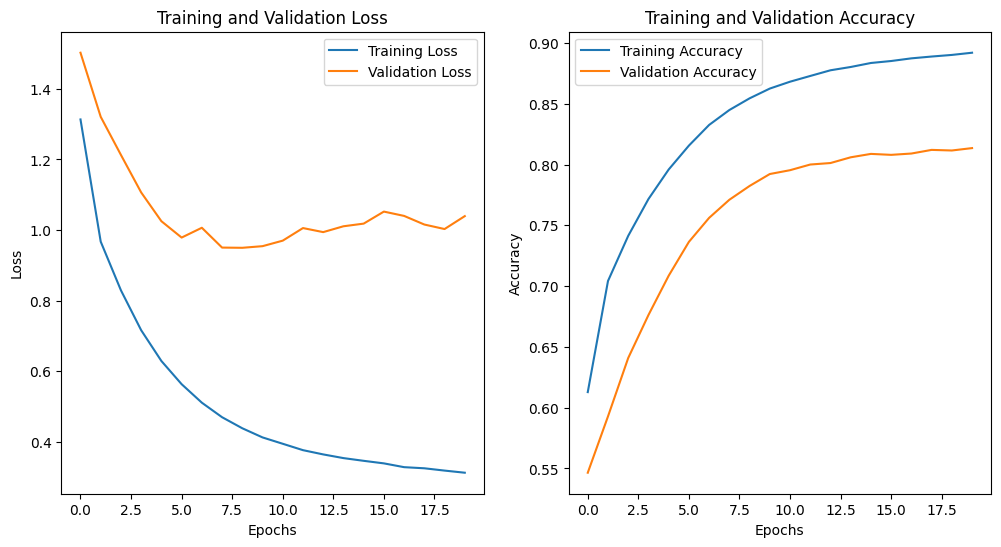

(<Sequential name=sequential, built=True>,
 TfidfVectorizer(max_features=7000, ngram_range=(1, 3)),
 LabelEncoder(),
 0.39008392693419847)

In [ ]:
tfidf_params = {
    'ngram_range': (1, 3),
    'max_features': 7000
}

train_neural_network(
    clean_final_train, cleaned_val_df, final_test_df,
    text_column="text",
    target_column="Country",
    tfidf_params =tfidf_params
)

In [ ]:
final_comparison_table['question_step_number'].append("5.1")
final_comparison_table['model_name'].append('DNN')
final_comparison_table['features'].append('TF-IDF, LabelEncoder')
final_comparison_table['model_parameters'].append('ngram_range:(1, 2), max_features:5000')
final_comparison_table['preprocessing_methods'].append("remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags")
final_comparison_table['accuracy'].append('0.3901')
final_comparison_table['f1_score'].append('0.3756')

In [ ]:
final_comparison = pd.DataFrame(final_comparison_table)
pd.set_option('display.max_colwidth', None)
final_comparison

,question_step_number,model_name,features,model_parameters,preprocessing_methods,accuracy,f1_score
0,4.6,MultinomialNB,TF-IDF,"ngram_range:(1, 3), min_df:5, max_df:0.90, max_features:15000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.375979,0.406986
1,5.1,DNN,"TF-IDF, LabelEncoder","ngram_range:(1, 2), max_features:5000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.3901,0.3756


In [ ]:

final_comparison.to_excel('final_comparison.xlsx', index=False)

from google.colab import files
files.download('final_comparison.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## [5.2]

In [ ]:
clean_final_train['text_tokens'] = final_train_df['text_tokens'].apply(
    lambda x: text_processing_pipeline(' '.join(x), cleaning_step).split())
clean_final_train["text_tokens"]

,text_tokens
0,"[استاذ, عبدالعزيز, صارله, الموضوع, سنه, يعني, ..."
1,"[كذبة_نيسان, كل, عام, والكذاب, بألف, خير]"
2,"[طمطم, عااتى, طبق, جبنة]"
3,"[يمكن, متلاحقين, السوق, بيشترون, سمك, للغداء]"
4,"[عيل, المدرب, حمار, حشاك, مالها, حل, ثالث, هم,..."
...,...
104116,"[في, تواليت, في, المحطة]"
104117,"[خليه, طويل]"
104118,"[وفلي, المازوت]"
104119,"[نجم, ناخو, زوز, بلايص, فاضين, لليلة, ؟]"


In [ ]:
empty_cells = clean_final_train[clean_final_train['text_tokens'].apply(lambda x: len(x) == 0 or not x)]
clean_final_train = clean_final_train[clean_final_train['text_tokens'].apply(lambda x: len(' '.join(x)) >= 5)]

Prepare data

In [ ]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(clean_final_train["text"])

X_train = pad_sequences(tokenizer.texts_to_sequences(clean_final_train["text"]), maxlen=MAX_SEQUENCE_LENGTH)
X_val = pad_sequences(tokenizer.texts_to_sequences(cleaned_val_df["text"]), maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(final_test_df["text"]), maxlen=MAX_SEQUENCE_LENGTH)

label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(clean_final_train["Country"])
Y_val = label_encoder.transform(cleaned_val_df["Country"])
Y_test = label_encoder.transform(final_test_df["Country"])

In [ ]:
def plot_learning_curves(history):

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


### [5.2.1]

In [ ]:
def build_cnn_with_trainable_embedding(vocab_size, embed_dim, input_length, num_classes):
    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=input_length, trainable=True),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model1 = build_cnn_with_trainable_embedding(MAX_VOCAB_SIZE, 100, MAX_SEQUENCE_LENGTH, len(label_encoder.classes_))
history1 = model1.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=32, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.4884 - loss: 1.7148 - val_accuracy: 0.5682 - val_loss: 1.3989
Epoch 2/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7348 - loss: 0.8583 - val_accuracy: 0.6390 - val_loss: 1.1812
Epoch 3/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7837 - loss: 0.6750 - val_accuracy: 0.6958 - val_loss: 1.0099
Epoch 4/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8209 - loss: 0.5491 - val_accuracy: 0.7348 - val_loss: 0.9207
Epoch 5/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8495 - loss: 0.4572 - val_accuracy: 0.7666 - val_loss: 0.8831
Epoch 6/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8679 - loss: 0.3921 - val_accuracy: 0.7899 - val_loss: 0.8845
Epoch 7/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8853 - loss: 0.3443 - val_accuracy: 0.8049 - val_loss: 0.8943
Epoch 8/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8968 - loss: 0

In [ ]:
loss, accuracy = model1.evaluate(X_test, Y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

Y_pred_probs = model1.predict(X_test)
Y_pred = Y_pred_probs.argmax(axis=1)
f1 = f1_score(Y_test, Y_pred, average='weighted')
print(f"F1-Score: {f1:.4f}")

Test Accuracy: 0.3914
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
F1-Score: 0.3752


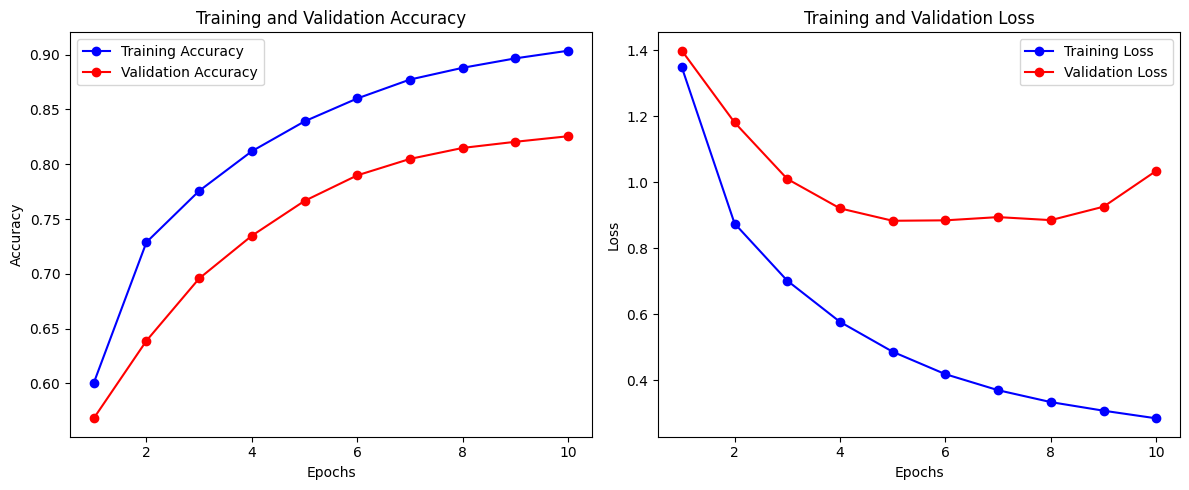

In [ ]:
plot_learning_curves(history1)

In [ ]:
final_comparison_table['question_step_number'].append("5.2.1")
final_comparison_table['model_name'].append('CNN_with_trainable_embedding')
final_comparison_table['features'].append('pad_sequences, \nLabelEncoder')
final_comparison_table['model_parameters'].append('MAX_SEQUENCE_LENGTH=100, \nMAX_VOCAB_SIZE=20000')
final_comparison_table['preprocessing_methods'].append("remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags")
final_comparison_table['accuracy'].append('0.3914')
final_comparison_table['f1_score'].append('0.3752')


In [ ]:
final_comparison = pd.DataFrame(final_comparison_table)
pd.set_option('display.max_colwidth', None)
final_comparison

,question_step_number,model_name,features,model_parameters,preprocessing_methods,accuracy,f1_score
0,4.6,MultinomialNB,TF-IDF,"ngram_range:(1, 3), min_df:5, max_df:0.90, max_features:15000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.375979,0.406986
1,5.2.1,CNN_with_trainable_embedding,"pad_sequences, \nLabelEncoder","MAX_SEQUENCE_LENGTH=100, \nMAX_VOCAB_SIZE=20000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.3914,0.3752


### [5.2.2]

embedding_matrix (FastTesxt model)

In [ ]:
vocab = set(word for tokens in clean_final_train['text_tokens'] for word in tokens)

embedding_dim = fasttext_model.vector_size
embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))

word_to_index = {}
index_to_word = {}
for idx, word in enumerate(vocab, start=1):
    if word in fasttext_model:
        embedding_matrix[idx] = fasttext_model[word]
    else:
        embedding_matrix[idx] = np.zeros(embedding_dim)
    word_to_index[word] = idx
    index_to_word[idx] = word

print("Shape of embedding_matrix:", embedding_matrix.shape)
print("Number of unique words in vocabulary:", len(vocab))

In [ ]:
#np.savez("embedding_data.npz", embedding_matrix=embedding_matrix, tokenizer=tokenizer)

# تحميل المصفوفة
data = np.load('/content/drive/MyDrive/embedding_data.npz', allow_pickle=True)
embedding_matrix = data['embedding_matrix']
tokenizer = data['tokenizer'].item()

In [ ]:
def build_cnn_with_frozen_embedding(embedding_matrix, input_length, num_classes):
    vocab_size, embed_dim = embedding_matrix.shape
    model = Sequential([
        Embedding(vocab_size, embed_dim, weights=[embedding_matrix], input_length=input_length, trainable=False),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
model2 = build_cnn_with_frozen_embedding(embedding_matrix, MAX_SEQUENCE_LENGTH,
                                         len(label_encoder.classes_))

history2 = model2.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                     batch_size=32, epochs=10,
                      verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.3693 - loss: 2.1002 - val_accuracy: 0.3827 - val_loss: 2.0964
Epoch 2/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5338 - loss: 1.5456 - val_accuracy: 0.4245 - val_loss: 1.9001
Epoch 3/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5822 - loss: 1.3651 - val_accuracy: 0.4493 - val_loss: 1.7841
Epoch 4/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6154 - loss: 1.2523 - val_accuracy: 0.4690 - val_loss: 1.7306
Epoch 5/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6358 - loss: 1.1669 - val_accuracy: 0.4946 - val_loss: 1.6468
Epoch 6/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6528 - loss: 1.0991 - val_accuracy: 0.5136 - val_loss: 1.5854
Epoch 7/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6660 - loss: 1.0478 - val_accuracy: 0.5236 - val_loss: 1.5719
Epoch 8/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6813 - loss: 1.

In [ ]:
loss, accuracy = model2.evaluate(X_test, Y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

Y_pred_probs = model2.predict(X_test)
Y_pred = Y_pred_probs.argmax(axis=1)
f1 = f1_score(Y_test, Y_pred, average='weighted')
print(f"F1-Score: {f1:.4f}")

Test Accuracy: 0.2723
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
F1-Score: 0.2363


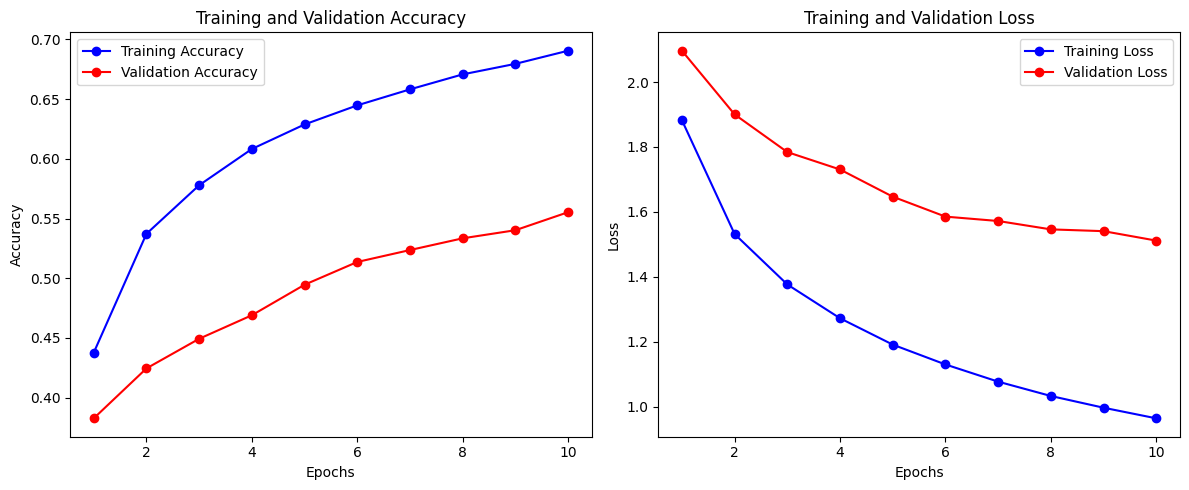

In [ ]:
plot_learning_curves(history2)

In [ ]:
final_comparison_table['question_step_number'].append("5.2.2")
final_comparison_table['model_name'].append('CNN_with_frozen_embedding')
final_comparison_table['features'].append('pad_sequences, \nLabelEncoder')
final_comparison_table['model_parameters'].append('MAX_SEQUENCE_LENGTH=100, \nMAX_VOCAB_SIZE=20000')
final_comparison_table['preprocessing_methods'].append("remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags")
final_comparison_table['accuracy'].append('0.2723')
final_comparison_table['f1_score'].append('0.2363')

final_comparison = pd.DataFrame(final_comparison_table)
pd.set_option('display.max_colwidth', None)
final_comparison

,question_step_number,model_name,features,model_parameters,preprocessing_methods,accuracy,f1_score
0,4.6,MultinomialNB,TF-IDF,"ngram_range:(1, 3), min_df:5, max_df:0.90, max_features:15000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.375979,0.406986
1,5.2.1,CNN_with_trainable_embedding,"pad_sequences, \nLabelEncoder","MAX_SEQUENCE_LENGTH=100, \nMAX_VOCAB_SIZE=20000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.3914,0.3752
2,5.2.2,CNN_with_frozen_embedding,"pad_sequences, \nLabelEncoder","MAX_SEQUENCE_LENGTH=100, \nMAX_VOCAB_SIZE=20000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.2723,0.2363


### [5.2.3]

In [ ]:
def build_cnn_with_trainable_pretrained_embedding(embedding_matrix, input_length, num_classes):
    vocab_size, embed_dim = embedding_matrix.shape
    model = Sequential([
        Embedding(vocab_size, embed_dim, weights=[embedding_matrix], input_length=input_length, trainable=True),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
model3 = build_cnn_with_trainable_pretrained_embedding(embedding_matrix, MAX_SEQUENCE_LENGTH,
                                                       len(label_encoder.classes_))

history3 = model3.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                      epochs=10, batch_size=32, verbose=1)

Epoch 1/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 1760s 539ms/step - accuracy: 0.5178 - loss: 1.6328 - val_accuracy: 0.5917 - val_loss: 1.3456
Epoch 2/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 1768s 541ms/step - accuracy: 0.7472 - loss: 0.8180 - val_accuracy: 0.6680 - val_loss: 1.1047
Epoch 3/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 1701s 522ms/step - accuracy: 0.8026 - loss: 0.6165 - val_accuracy: 0.7289 - val_loss: 0.9199
Epoch 4/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 1681s 516ms/step - accuracy: 0.8426 - loss: 0.4878 - val_accuracy: 0.7812 - val_loss: 0.8507
Epoch 5/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 1690s 513ms/step - accuracy: 0.8693 - loss: 0.3989 - val_accuracy: 0.8051 - val_loss: 0.7748
Epoch 6/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 1658s 510ms/step - accuracy: 0.8856 - loss: 0.3469 - val_accuracy: 0.8140 - val_loss: 0.7618
Epoch 7/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 1727s 517ms/step - accuracy: 0.8962 - loss: 0.3080 - val_accuracy: 0.8252 - val_loss: 0.7837
Epoch 8/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 1734s 527ms/s

In [ ]:
loss, accuracy = model3.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Y_pred_probs = model3.predict(X_test)
Y_pred = Y_pred_probs.argmax(axis=1)
f1 = f1_score(Y_test, Y_pred, average='weighted')
print(f"F1-Score: {f1:.4f}")

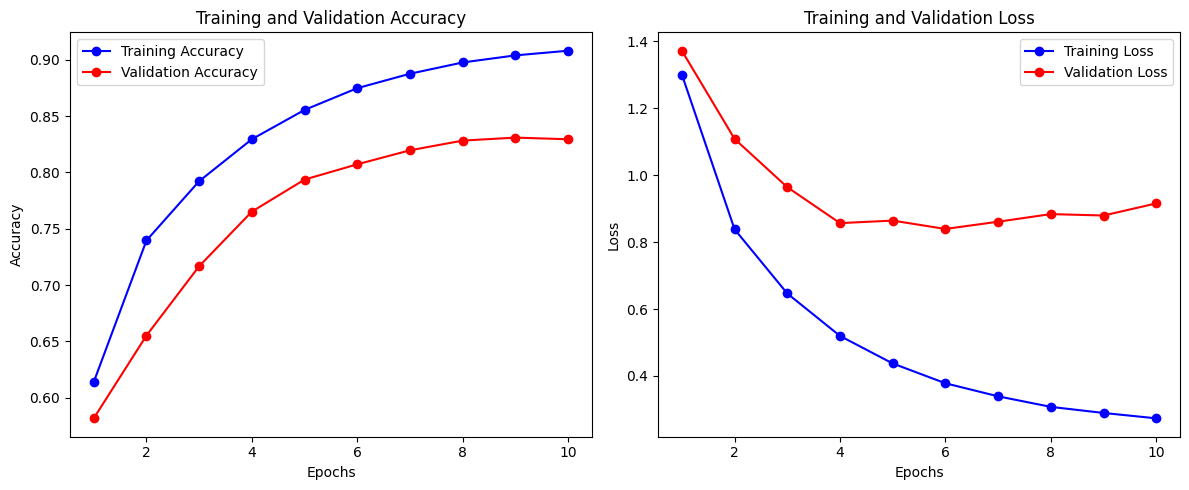

In [ ]:
plot_learning_curves(history3)

In [ ]:
final_comparison_table['question_step_number'].append("5.2.3")
final_comparison_table['model_name'].append('CNN_with_trainable_pretrained_embedding')
final_comparison_table['features'].append('pad_sequences, \nLabelEncoder')
final_comparison_table['model_parameters'].append('MAX_SEQUENCE_LENGTH=100, \nMAX_VOCAB_SIZE=20000')
final_comparison_table['preprocessing_methods'].append("remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags")
final_comparison_table['accuracy'].append('0.3991')
final_comparison_table['f1_score'].append('0.3867')

final_comparison = pd.DataFrame(final_comparison_table)
pd.set_option('display.max_colwidth', None)
final_comparison

,question_step_number,model_name,features,model_parameters,preprocessing_methods,accuracy,f1_score
0,4.6,MultinomialNB,TF-IDF,"ngram_range:(1, 3), min_df:5, max_df:0.90, max_features:15000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.375979,0.406986
1,5.2.1,CNN_with_trainable_embedding,"pad_sequences, \nLabelEncoder","MAX_SEQUENCE_LENGTH=100, \nMAX_VOCAB_SIZE=20000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.3914,0.3752
2,5.2.2,CNN_with_frozen_embedding,"pad_sequences, \nLabelEncoder","MAX_SEQUENCE_LENGTH=100, \nMAX_VOCAB_SIZE=20000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.2723,0.2363
3,5.2.3,CNN_with_trainable_pretrained_embedding,"pad_sequences, \nLabelEncoder","MAX_SEQUENCE_LENGTH=100, \nMAX_VOCAB_SIZE=20000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.3991,0.3867


## [5.3]

In [ ]:
final_comparison.to_csv('final_comparison.csv', index=False)

# from google.colab import files

# # لتحميل ملف CSV
# final_comparison.to_csv('final_comparison.csv', index=False)
# files.download('final_comparison.csv')

In [ ]:
# تحميل المصفوفة والقاموس
data = np.load("embedding_data.npz", allow_pickle=True)
embedding_matrix = data['embedding_matrix']
tokenizer = data['tokenizer'].item()

In [ ]:
best_embedding_matrix = embedding_matrix
trainable_embedding = True

def final_model(filters, kernel_size, dense_units, dropout_rate, learning_rate):
    model = Sequential([
        Embedding(input_dim=best_embedding_matrix.shape[0],
                  output_dim=best_embedding_matrix.shape[1],
                  weights=[best_embedding_matrix],
                  input_length=MAX_SEQUENCE_LENGTH,
                  trainable=trainable_embedding),
        Conv1D(filters, kernel_size, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

<div dir='rtl'>
لفجوة بين أداء التدريب والتحقق تشير إلى وجود مشكلة في التعميم (Generalization)، وهي علامة على overfitting.
</div>
<div dir='rtl'>
سنقوم بتعديل على البارامترات بشكل يدوي (manual tuning 😑)
</div>
<div dir='rtl'>
وذلك بسبب قلة الموارد، حيث أن الطرق الاوتوماتيكية مثل grid search وغيرها أخذت وقتا طويلا وبالنهاية تم استهلاك جميع الرامات.
</div>

In [ ]:
filters = 128
kernel_size = 5
dense_units = 64
dropout_rate = 0.4
learning_rate = 0.001


model = final_model(filters, kernel_size, dense_units, dropout_rate, learning_rate)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)


history = model.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.5273 - loss: 1.6129 - val_accuracy: 0.0896 - val_loss: 5.7041
Epoch 2/20
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - accuracy: 0.7518 - loss: 0.8108 - val_accuracy: 0.1038 - val_loss: 5.8028
Epoch 3/20
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.7987 - loss: 0.6205 - val_accuracy: 0.1130 - val_loss: 7.0781
Epoch 4/20
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8395 - loss: 0.4824 - val_accuracy: 0.1194 - val_loss: 7.8322
Epoch 5/20
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - accuracy: 0.8660 - loss: 0.4002 - val_accuracy: 0.1208 - val_loss: 10.5356
Epoch 6/20
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - accuracy: 0.8854 - loss: 0.3391 - val_accuracy: 0.1240 - val_loss: 11.5815
Epoch 7/20
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.8993 - loss: 0.2963 - val_accuracy: 0.1201 - val_loss: 14.2421


In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

Y_pred_probs = model.predict(X_test)
Y_pred = Y_pred_probs.argmax(axis=1)
f1 = f1_score(Y_test, Y_pred, average='weighted')
print(f"F1-Score: {f1:.4f}")

Test Accuracy: 0.3325
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
F1-Score: 0.2785


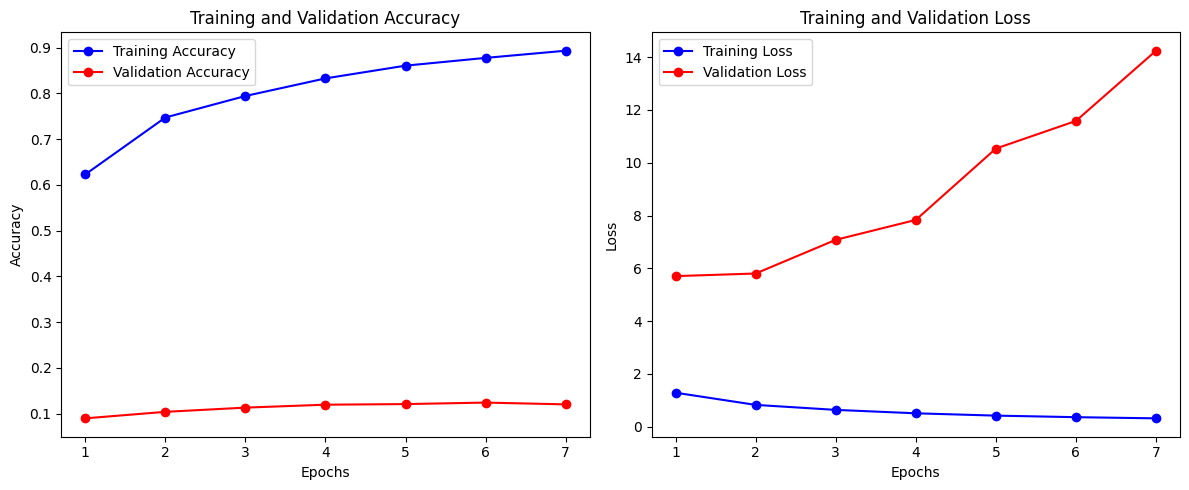

In [ ]:
plot_learning_curves(history)

In [ ]:
final_comparison_table['question_step_number'].append("5.3")
final_comparison_table['model_name'].append('best model')
final_comparison_table['features'].append('pad_sequences, \nLabelEncoder')
final_comparison_table['model_parameters'].append('filters = 96, \nkernel_size = 5, \ndense_units = 48, \ndropout_rate = 0.4, \nlearning_rate = 0.001, \nepochs=20, \nEarlyStopping')
final_comparison_table['preprocessing_methods'].append("remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags")
final_comparison_table['accuracy'].append('0.3243')
final_comparison_table['f1_score'].append('0.2602')

final_comparison = pd.DataFrame(final_comparison_table)
pd.set_option('display.max_colwidth', None)
final_comparison



,question_step_number,model_name,features,model_parameters,preprocessing_methods,accuracy,f1_score
0,4.6,MultinomialNB,TF-IDF,"ngram_range:(1, 3), min_df:5, max_df:0.90, max_features:15000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.375979,0.406986
1,5.2.1,CNN_with_trainable_embedding,"pad_sequences, \nLabelEncoder","MAX_SEQUENCE_LENGTH=100, \nMAX_VOCAB_SIZE=20000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.3914,0.3752
2,5.2.2,CNN_with_frozen_embedding,"pad_sequences, \nLabelEncoder","MAX_SEQUENCE_LENGTH=100, \nMAX_VOCAB_SIZE=20000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.2723,0.2363
3,5.2.3,CNN_with_trainable_pretrained_embedding,"pad_sequences, \nLabelEncoder","MAX_SEQUENCE_LENGTH=100, \nMAX_VOCAB_SIZE=20000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.3991,0.3867
4,5.3,best model,"pad_sequences, \nLabelEncoder","filters = 64, \nkernel_size = 5, \ndense_units = 32, \ndropout_rate = 0.5, \nlearning_rate = 0.0005, \nepochs=20, \nEarlyStopping","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.2777,0.1959
5,5.3,best model,"pad_sequences, \nLabelEncoder","filters = 96, \nkernel_size = 5, \ndense_units = 48, \ndropout_rate = 0.4, \nlearning_rate = 0.001, \nepochs=20, \nEarlyStopping","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.3243,0.2602


<div dir ='rtl'>
تطبيق Regularization للحد من overfit
</div>

In [ ]:
from tensorflow.keras import regularizers

def final_model(filters, kernel_size, dense_units, dropout_rate, learning_rate):
    model = Sequential([
        Embedding(input_dim=best_embedding_matrix.shape[0],
                  output_dim=best_embedding_matrix.shape[1],
                  weights=[best_embedding_matrix],
                  input_length=MAX_SEQUENCE_LENGTH,
                  trainable=trainable_embedding),


        Conv1D(filters, kernel_size, activation='relu',
               kernel_regularizer=regularizers.l2(0.001)),

        GlobalMaxPooling1D(),


        Dense(dense_units, activation='relu',
              kernel_regularizer=regularizers.l2(0.001)),

        Dropout(dropout_rate),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
filters = 128
kernel_size = 5
dense_units = 64
dropout_rate = 0.3
learning_rate = 0.001


model = final_model(filters, kernel_size, dense_units, dropout_rate, learning_rate)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


history = model.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/20
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.5397 - loss: 1.7415 - val_accuracy: 0.0936 - val_loss: 4.8722
Epoch 2/20
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.7388 - loss: 0.9851 - val_accuracy: 0.1017 - val_loss: 5.3584
Epoch 3/20
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.7836 - loss: 0.8094 - val_accuracy: 0.1105 - val_loss: 5.5220
Epoch 4/20
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.8100 - loss: 0.7131 - val_accuracy: 0.1194 - val_loss: 5.5640


In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

Y_pred_probs = model.predict(X_test)
Y_pred = Y_pred_probs.argmax(axis=1)
f1 = f1_score(Y_test, Y_pred, average='weighted')
print(f"F1-Score: {f1:.4f}")

Test Accuracy: 0.3345
444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
F1-Score: 0.2827


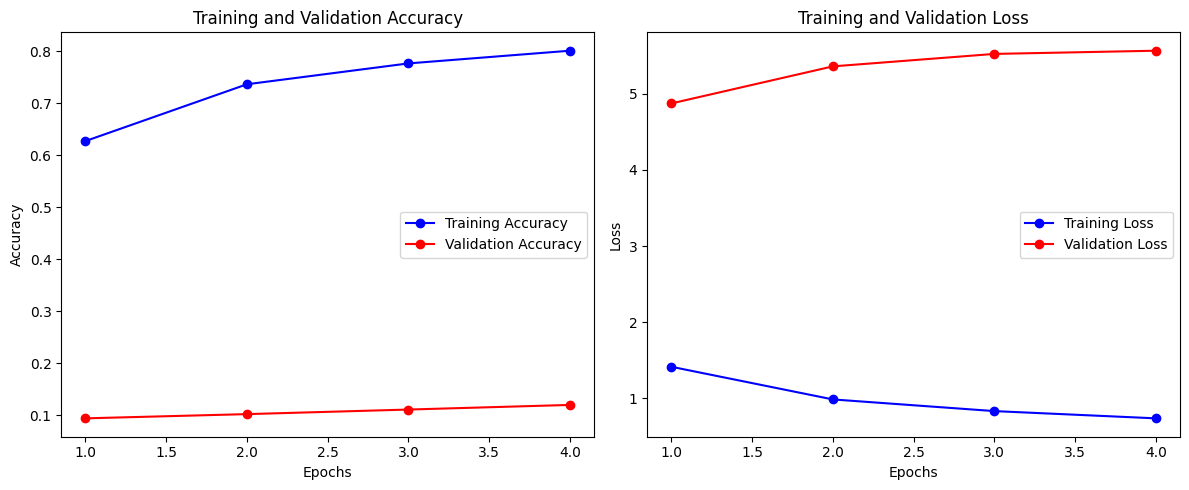

In [ ]:
plot_learning_curves(history)

In [ ]:
final_comparison_table['question_step_number'].append("5.3")
final_comparison_table['model_name'].append('best model')
final_comparison_table['features'].append('pad_sequences, \nLabelEncoder')
final_comparison_table['model_parameters'].append('filters = 128, \nkernel_size = 5, \ndense_units = 64, \ndropout_rate = 0.3, \nlearning_rate = 0.001, \nepochs=20, \nEarlyStopping, \nregularizers.l2(0.001)')
final_comparison_table['preprocessing_methods'].append("remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags")
final_comparison_table['accuracy'].append('0.3345')
final_comparison_table['f1_score'].append('0.2827')

final_comparison = pd.DataFrame(final_comparison_table)
pd.set_option('display.max_colwidth', None)
final_comparison



,question_step_number,model_name,features,model_parameters,preprocessing_methods,accuracy,f1_score
0,4.6,MultinomialNB,TF-IDF,"ngram_range:(1, 3), min_df:5, max_df:0.90, max_features:15000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.375979,0.406986
1,5.2.1,CNN_with_trainable_embedding,"pad_sequences, \nLabelEncoder","MAX_SEQUENCE_LENGTH=100, \nMAX_VOCAB_SIZE=20000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.3914,0.3752
2,5.2.2,CNN_with_frozen_embedding,"pad_sequences, \nLabelEncoder","MAX_SEQUENCE_LENGTH=100, \nMAX_VOCAB_SIZE=20000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.2723,0.2363
3,5.2.3,CNN_with_trainable_pretrained_embedding,"pad_sequences, \nLabelEncoder","MAX_SEQUENCE_LENGTH=100, \nMAX_VOCAB_SIZE=20000","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.3991,0.3867
4,5.3,best model,"pad_sequences, \nLabelEncoder","filters = 64, \nkernel_size = 5, \ndense_units = 32, \ndropout_rate = 0.5, \nlearning_rate = 0.0005, \nepochs=20, \nEarlyStopping","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.2777,0.1959
5,5.3,best model,"pad_sequences, \nLabelEncoder","filters = 96, \nkernel_size = 5, \ndense_units = 48, \ndropout_rate = 0.4, \nlearning_rate = 0.001, \nepochs=20, \nEarlyStopping","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.3243,0.2602
6,5.3,best model,"pad_sequences, \nLabelEncoder","filters = 128, \nkernel_size = 5, \ndense_units = 64, \ndropout_rate = 0.3, \nlearning_rate = 0.001, \nepochs=20, \nEarlyStopping, \nregularizers.l2(0.001)","remove_urls, remove_emojis, remove_numbers, normalize_repeated_chars, remove_non_arabic_words, remove_extra_spaces, remove_hashtags",0.3345,0.2827


In [ ]:
final_comparison.to_csv('final_comparison.csv', index=False)

# from google.colab import files

# # لتحميل ملف CSV
# final_comparison.to_csv('final_comparison.csv', index=False)
# files.download('final_comparison.csv')

<div dir='rtl'>
النتائج السابقة كانت نتيجة اختيار ال hyper_parameters يدويا.
</div>
<div dir='rtl'>
الان سنقوم بضبط المتغيرات باستخدام Grid Search
</div>

In [ ]:
# إعداد المتغيرات الأساسية
vocab_size = 20000  # حجم المفردات
embed_dim = 100  # أبعاد التضمين
input_length = 100  # طول النصوص
num_classes = len(set(Y_train))  # عدد الفئات


In [ ]:
# قائمة قيم hyper-parameters لتجربتها
filters_list = [64, 128]
kernel_size_list = [3, 5]
dense_units_list = [64, 128, 256]
dropout_rate_list = [0.3, 0.5]
learning_rate_list = [0.001, 0.05]
filters = 128
kernel_size = 5
dense_units = 64
dropout_rate = 0.4
learning_rate = 0.001

results = []

for filters in filters_list:
    for kernel_size in kernel_size_list:
        for dense_units in dense_units_list:
            for dropout_rate in dropout_rate_list:
                for learning_rate in learning_rate_list:
                    print(f"Training with filters={filters}, kernel_size={kernel_size}, dense_units={dense_units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}")

                    # إنشاء النموذج
                    model = build_model(filters, kernel_size, dense_units, dropout_rate, learning_rate)

                    # تدريب النموذج
                    model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_val, Y_val))

                    # التقييم على بيانات الاختبار
                    y_pred = model.predict(X_test).argmax(axis=1)

                    accuracy = accuracy_score(Y_test, y_pred)
                    f1 = f1_score(Y_test, y_pred, average="weighted")

                    print(f"Test Accuracy: {accuracy}")
                    print(f"Test F1-Score: {f1}")

                    # حفظ النتائج
                    results.append({
                        "filters": filters,
                        "kernel_size": kernel_size,
                        "dense_units": dense_units,
                        "dropout_rate": dropout_rate,
                        "learning_rate": learning_rate,
                        "accuracy": accuracy,
                        "f1_score": f1
                    })

results_df = pd.DataFrame(results)
print(results_df)

# عرض أفضل القيم
best_result = results_df.loc[results_df["accuracy"].idxmax()]
print("Best Configuration:")
print(best_result)


Training with filters=64, kernel_size=3, dense_units=64, dropout_rate=0.3, learning_rate=0.001
Epoch 1/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 323s 99ms/step - accuracy: 0.1415 - loss: 2.7364 - val_accuracy: 0.1352 - val_loss: 2.9037
Epoch 2/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 305s 94ms/step - accuracy: 0.1432 - loss: 2.5890 - val_accuracy: 0.1352 - val_loss: 2.9308
Epoch 3/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 320s 93ms/step - accuracy: 0.1418 - loss: 2.5901 - val_accuracy: 0.1352 - val_loss: 2.9369
Epoch 4/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 322s 93ms/step - accuracy: 0.1418 - loss: 2.5874 - val_accuracy: 0.1352 - val_loss: 2.9381
Epoch 5/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 319s 92ms/step - accuracy: 0.1449 - loss: 2.5861 - val_accuracy: 0.1352 - val_loss: 2.9396
Epoch 6/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 321s 92ms/step - accuracy: 0.1394 - loss: 2.5965 - val_accuracy: 0.1352 - val_loss: 2.9398
Epoch 7/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 323s 92ms/step - accuracy: 0.1415 - loss: 2.5912 - val_accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 305s 93ms/step - accuracy: 0.1356 - loss: 2.6036 - val_accuracy: 0.1352 - val_loss: 2.9283
Epoch 2/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 299s 92ms/step - accuracy: 0.1378 - loss: 2.5957 - val_accuracy: 0.1352 - val_loss: 2.9384
Epoch 3/10
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 323s 92ms/step - accuracy: 0.1375 - loss: 2.5954 - val_accuracy: 0.1352 - val_loss: 2.9253
Epoch 4/10
1647/3254 ━━━━━━━━━━━━━━━━━━━━ 2:30 93ms/step - accuracy: 0.1356 - loss: 2.6006

KeyboardInterrupt: 

## [5.4]

<div dir='rtl'>
تم اختيار الموديل من 5.2.3
</div>

In [ ]:
true_labels = Y_test
predicted_labels = model3.predict(X_test)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_classes))

f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1-Score (Weighted): {f1}")


## [5.5]

## [5.6]

# مهمة 06 : التمثيل الداللي

Semantic representation

## [6.1]

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# استخراج التضمينات من النموذج الأفضل
embeddings = model.layers[embedding_layer_index].get_weights()[0]

# تقليل الأبعاد باستخدام PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# تقليل الأبعاد باستخدام t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(embeddings)

# رسم PCA
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, edgecolors='k')
plt.title("Embedding Visualization using PCA")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()

# رسم t-SNE
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6, edgecolors='k')
plt.title("Embedding Visualization using t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


## [6.2]

In [ ]:
def extract_embeddings_from_model(model, vocab_size):
    """
    استخراج التضمينات من طبقة التضمين في النموذج المدرب.

    :param model: النموذج المدرب.
    :param vocab_size: حجم القاموس.
    :return: التضمينات.
    """
    embedding_layer = model.layers[0]
    embeddings = embedding_layer.get_weights()[0]
    return embeddings[:vocab_size]


# Final Results

In [ ]:
df = pd.DataFrame(comparison_table)
df

,question_step_number,model_name,features,model_parameters,preprocessing_methods,Training Accuracy,Validation Accuracy,Test Accuracy,Training F1_score,Validation F1_score,Test F1_score
0,4.3,MultinomialNB_TFIDF,TF-IDF,default,non,0.714774,0.534179,0.354397,0.67665,0.467715,0.290655


In [ ]:
df.to_csv("[your_name].csv", index=False)